# <div align="center"> <font color='red'>🦠Colon Cancer Cell Classification🦠</font></div>

## Problem statement




This project aims to design and implement a machine learning based classification system for histopathology images of colon cells, utilizing a modified version of the CRCHistoPhenotypes dataset. The classification system must address two primry tasks:
* **Cancer Detection:** Determine whether a given 27x27 RGB image of a colon cell is cancerous or non-cancerous (isCancerous label).
* **Cell-type Classification:** Classify each cell image into one of the following categories: fibroblast, inflammatory, epithelial, or others (cell-type label).

##  Data Loading

In [5]:
import pandas as pd

main_data = pd.read_csv('data_labels_mainData.csv')
extra_data = pd.read_csv('data_labels_extraData.csv')

print(main_data.head())
print(extra_data.head())

   InstanceID  patientID  ImageName cellTypeName  cellType  isCancerous
0       22405          1  22405.png   fibroblast         0            0
1       22406          1  22406.png   fibroblast         0            0
2       22407          1  22407.png   fibroblast         0            0
3       22408          1  22408.png   fibroblast         0            0
4       22409          1  22409.png   fibroblast         0            0
   InstanceID  patientID  ImageName  isCancerous
0       12681         61  12681.png            0
1       12682         61  12682.png            0
2       12683         61  12683.png            0
3       12684         61  12684.png            0
4       12685         61  12685.png            0


first 5 images: ['3975.png', '17843.png', '21329.png', '8820.png', '14392.png']


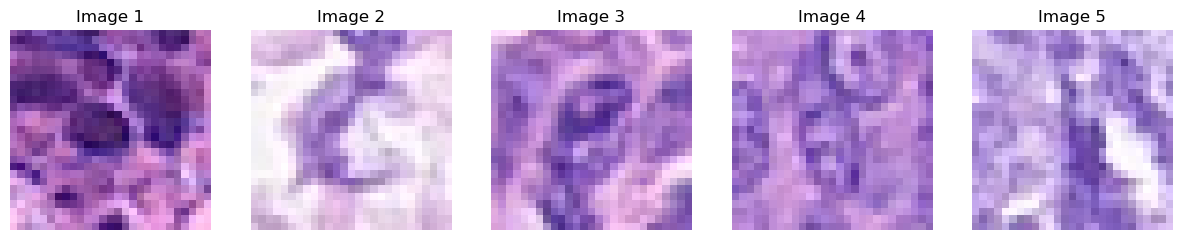

In [6]:
import os
from PIL import Image
import matplotlib.pyplot as plt

image_folder = 'patch_images'

image_files = os.listdir(image_folder)
print("first 5 images:", image_files[:5])

num_samples = 5  
plt.figure(figsize=(15, 5))

for i in range(num_samples):
    img_path = os.path.join(image_folder, image_files[i])
    img = Image.open(img_path)

    
    plt.subplot(1, num_samples, i+1)
    plt.imshow(img)
    
    plt.title(f"Image {i+1}")
    plt.axis('off')
plt.show()


**Sample image Observation**: All patches appear to be H and E stained(hematoxylin and eosin), showing purples and pinks that reflect nuclei and cytoplasm. However, some variations in brightness and contrast are evident across patches in these images.. No embedded text or labels are observed in these samples. Blur cmay negativly affect feature extraction later on.

## Data Overview

In [9]:
num_images = len(image_files)

num_main_data = main_data.shape[0]
num_extra_data = extra_data.shape[0]

main_patient_ids = main_data['patientID'].unique()
extra_patient_ids = extra_data['patientID'].unique()

main_patients_range = (main_patient_ids.min(), main_patient_ids.max())
extra_patients_range = (extra_patient_ids.min(), extra_patient_ids.max())

unique_cell_types = main_data['cellTypeName'].unique()

print("-------------------------------Data Overview -------------------------------------------\n")
print(f"Total nos of images in patch_images folder: {num_images}\n")


print("Patient Information:")
print(f"* Patients with full labels (main data): {len(main_patient_ids)} patients")
print(f"  (Patient IDs range from {main_patients_range[0]} to {main_patients_range[1]})")
print(f"* Patients with only isCancerous label (extra data): {len(extra_patient_ids)} patients")
print(f"  (Patient IDs range from {extra_patients_range[0]} to {extra_patients_range[1]})\n")


print("Label Information:")
print("- isCancerous: Binary label (1: Cancerous, 0: Non-cancerous)")  
print(f"* cellTypeName categories: {list(unique_cell_types)}\n")


print("Data Files:")
print(f"* data_labels_mainData.csv: {num_main_data} entries for patients {main_patients_range[0]}–{main_patients_range[1]}")
print(f"* data_labels_extraData.csv: {num_extra_data} entries for patients {extra_patients_range[0]}–{extra_patients_range[1]}\n")


print("Example Main Data Sample:")
print(main_data.iloc[0])


print("\nExample Extra Data Sample:")
print(extra_data.iloc[0])


#missing value check...
missing_main = main_data.isnull().sum()
missing_extra = extra_data.isnull().sum()
print("\nMissing Value Check:")
print("Main Data Missing Values:")
print(missing_main[missing_main > 0] if missing_main.sum() > 0 else "No missing values in main_data.")
print("\nExtra Data Missing Values:")
print(missing_extra[missing_extra > 0] if missing_extra.sum() > 0 else "No missing values in extra_data.")



#image mentioned in the csv file is present in the img folder or not..
missing_main_images = set(main_data['ImageName']) - set(image_files)
missing_extra_images = set(extra_data['ImageName']) - set(image_files)

if missing_main_images or missing_extra_images:
    print("\nMissing images detected:")
    if missing_main_images:
        print(f"- {len(missing_main_images)} missing in main_data")
    if missing_extra_images:
        print(f"- {len(missing_extra_images)} missing in extra_data")
else:
    print("\nAll image files referenced in CSVs are present in the patch_images folder.")


-------------------------------Data Overview -------------------------------------------

Total nos of images in patch_images folder: 20280

Patient Information:
* Patients with full labels (main data): 60 patients
  (Patient IDs range from 1 to 60)
* Patients with only isCancerous label (extra data): 38 patients
  (Patient IDs range from 61 to 99)

Label Information:
- isCancerous: Binary label (1: Cancerous, 0: Non-cancerous)
* cellTypeName categories: ['fibroblast', 'inflammatory', 'others', 'epithelial']

Data Files:
* data_labels_mainData.csv: 9896 entries for patients 1–60
* data_labels_extraData.csv: 10384 entries for patients 61–99

Example Main Data Sample:
InstanceID           22405
patientID                1
ImageName        22405.png
cellTypeName    fibroblast
cellType                 0
isCancerous              0
Name: 0, dtype: object

Example Extra Data Sample:
InstanceID         12681
patientID             61
ImageName      12681.png
isCancerous            0
Name: 0, dty

**Data Overview**
* The dataset consists of 20,280 histopathology image patches stored in the patch_images folder. It is split into two parts:
   * Main Data: Contains 9,896 labeled samples from 60 patients (IDs 1–60). Each sample includes:
      * isCancerous (binary label)
      * cellTypeName (multiclass label: fibroblast, inflammatory, others, epithelial)
   * Extra Data: Contains 10,384 samples from 38 patients (IDs 61–99). Only the isCancerous label is available(used in semi-supervised learning).
* All referenced images are present, and no missing values were found in either CSV file.

## Data Splitting

In [12]:
from sklearn.model_selection import train_test_split
from scipy.stats import mode
import numpy as np
from collections import Counter
import seaborn as sns
import tensorflow as tf


seed_value = 42
np.random.seed(seed_value)
tf.random.set_seed(seed_value)


#---------------------------------------- binary Classification: isCancerous --------------------------------------------#
#assign majority label (mode) to each patient...
binary_data = main_data.groupby('patientID')['isCancerous'].agg(lambda x: x.mode().iloc[0])
patients = binary_data.index.values
labels = binary_data.values

#patient-wise split..
train_p, temp_p, y_train_p, y_temp_p = train_test_split(patients, labels, stratify=labels, test_size=0.3, random_state=42)
val_p, test_p, y_val_p, y_test_p = train_test_split(temp_p, y_temp_p, stratify=y_temp_p, test_size=0.5, random_state=42)

#image-level labels....
train_binary = main_data[main_data['patientID'].isin(train_p)]
val_binary = main_data[main_data['patientID'].isin(val_p)]
test_binary = main_data[main_data['patientID'].isin(test_p)]

X_train_binary = train_binary['ImageName'].values
y_train_binary = train_binary['isCancerous'].values

X_val_binary = val_binary['ImageName'].values
y_val_binary = val_binary['isCancerous'].values

X_test_binary = test_binary['ImageName'].values
y_test_binary = test_binary['isCancerous'].values

# ------------------------------------------multiclass classification: cellTypeName ------------------------------------------#
#assign majority label (mode) to each patient...
multiclass_data = main_data.groupby('patientID')['cellTypeName'].agg(lambda x: x.mode().iloc[0])
patients_multi = multiclass_data.index.values
labels_multi = multiclass_data.values

#patient-wise split..
train_p_m, temp_p_m, y_train_m, y_temp_m = train_test_split(patients_multi, labels_multi, stratify=labels_multi, test_size=0.3, random_state=42)
val_p_m, test_p_m, y_val_m, y_test_m = train_test_split(temp_p_m, y_temp_m, stratify=y_temp_m, test_size=0.5, random_state=42)

#image-level labels....
train_multi = main_data[main_data['patientID'].isin(train_p_m)]
val_multi = main_data[main_data['patientID'].isin(val_p_m)]
test_multi = main_data[main_data['patientID'].isin(test_p_m)]

X_train_multi = train_multi['ImageName'].values
y_train_multi = train_multi['cellTypeName'].values

X_val_multi = val_multi['ImageName'].values
y_val_multi = val_multi['cellTypeName'].values

X_test_multi = test_multi['ImageName'].values
y_test_multi = test_multi['cellTypeName'].values


#-------------------------------------------summary ---------------------------------------------------#
print("Binary Classification (Patient-wise Split):")
print(f"*  Training patients: {len(train_p)} | Samples: {len(X_train_binary)}")
print(f"*  Validation patients: {len(val_p)} | Samples: {len(X_val_binary)}")
print(f"*  Testing patients: {len(test_p)} | Samples: {len(X_test_binary)}")
print(f"  Binary class balance (Train): Non-cancerous={sum(y_train_p==0)}, Cancerous={sum(y_train_p==1)}")

print("\nMulticlass Classification (Patient-wise Split):")
print(f"*  Training patients: {len(train_p_m)} | Samples: {len(X_train_multi)}")
print(f"*  Validation patients: {len(val_p_m)} | Samples: {len(X_val_multi)}")
print(f"*  Testing patients: {len(test_p_m)} | Samples: {len(X_test_multi)}")
print(f"  Multiclass class balance (Train): {dict(Counter(y_train_m))}")


Binary Classification (Patient-wise Split):
*  Training patients: 42 | Samples: 7073
*  Validation patients: 9 | Samples: 1244
*  Testing patients: 9 | Samples: 1579
  Binary class balance (Train): Non-cancerous=28, Cancerous=14

Multiclass Classification (Patient-wise Split):
*  Training patients: 42 | Samples: 6806
*  Validation patients: 9 | Samples: 1349
*  Testing patients: 9 | Samples: 1741
  Multiclass class balance (Train): {'others': 6, 'epithelial': 18, 'fibroblast': 8, 'inflammatory': 10}


### **Patient-wise Data Splitting & Class Distribution**

To avoid data leakage, we used **patient-wise splitting** instead of image-wise, as multiple images often come from the same patient. This ensures no patient appears in both training and test/validation sets, encouraging generalizable learning.

Even when patient IDs aren't available, data should be grouped by shared properties like ID to prevent the model from learning dataset specific artifacts rather than generalizable features like images.

#### **Why 70-15-15 Split?**
- **Train (70%)**: 42 patients (enough for learning).
- **Validation (15%)**: 9 patients (tuning, early stopping).
- **Test (15%)**: 9 patients (final evaluation).

#### **Why Stratified?**
- Maintains class balance (e.g., cancerous vs. non-cancerous, cell types).
- Prevents skewed test sets.

#### **Alternatives Explored**
- We explored alternatives like GroupShuffleSplit, StratifiedKFold, and StratifiedGroupKFold, but chose patient ID based splitting to avoid data leakage, and intentionally avoided K-Fold CV due to resource limits and the overhead of training multiple CNN test subsets.

#### **Class Distribution**
- **Binary (isCancerous)**: 7,073 train, 1,244 val, 1,579 test images.
  - 28 non-cancerous, 14 cancerous patients.
- **Multiclass (cellTypeName)**: 6,806 train, 1,349 val, 1,741 test.
  - 18 epithelial, 10 inflammatory, 8 fibroblast, 6 others.
  - ‘Others’ class is underrepresented.


## Exploratory Data Analysis(EDA) 

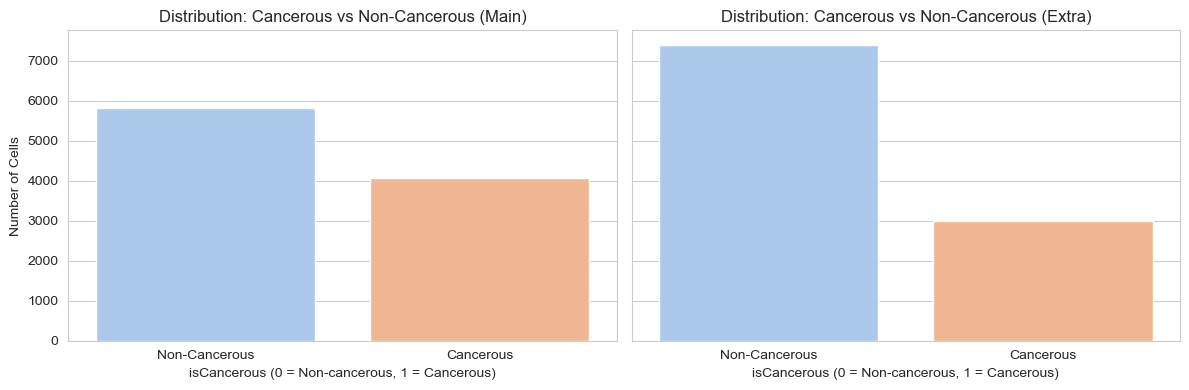

Class distribution (isCancerous) - Main Data:
Non-Cancerous: 5817 samples (58.78%)
Cancerous: 4079 samples (41.22%)

Class distribution (isCancerous) - Extra Data:
Non-Cancerous: 7394 samples (71.21%)
Cancerous: 2990 samples (28.79%)



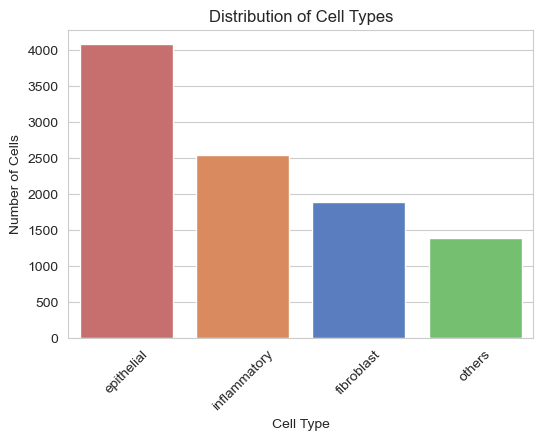

Class distribution (cellTypeName):
fibroblast: 1888 samples (19.08%)
inflammatory: 2543 samples (25.70%)
others: 1386 samples (14.01%)
epithelial: 4079 samples (41.22%)



<Figure size 600x400 with 0 Axes>

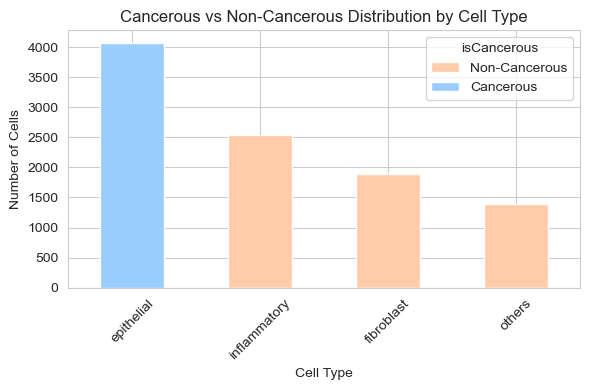

Cell Type vs isCancerous Distribution:
isCancerous      0     1
cellTypeName            
epithelial       0  4079
inflammatory  2543     0
fibroblast    1888     0
others        1386     0


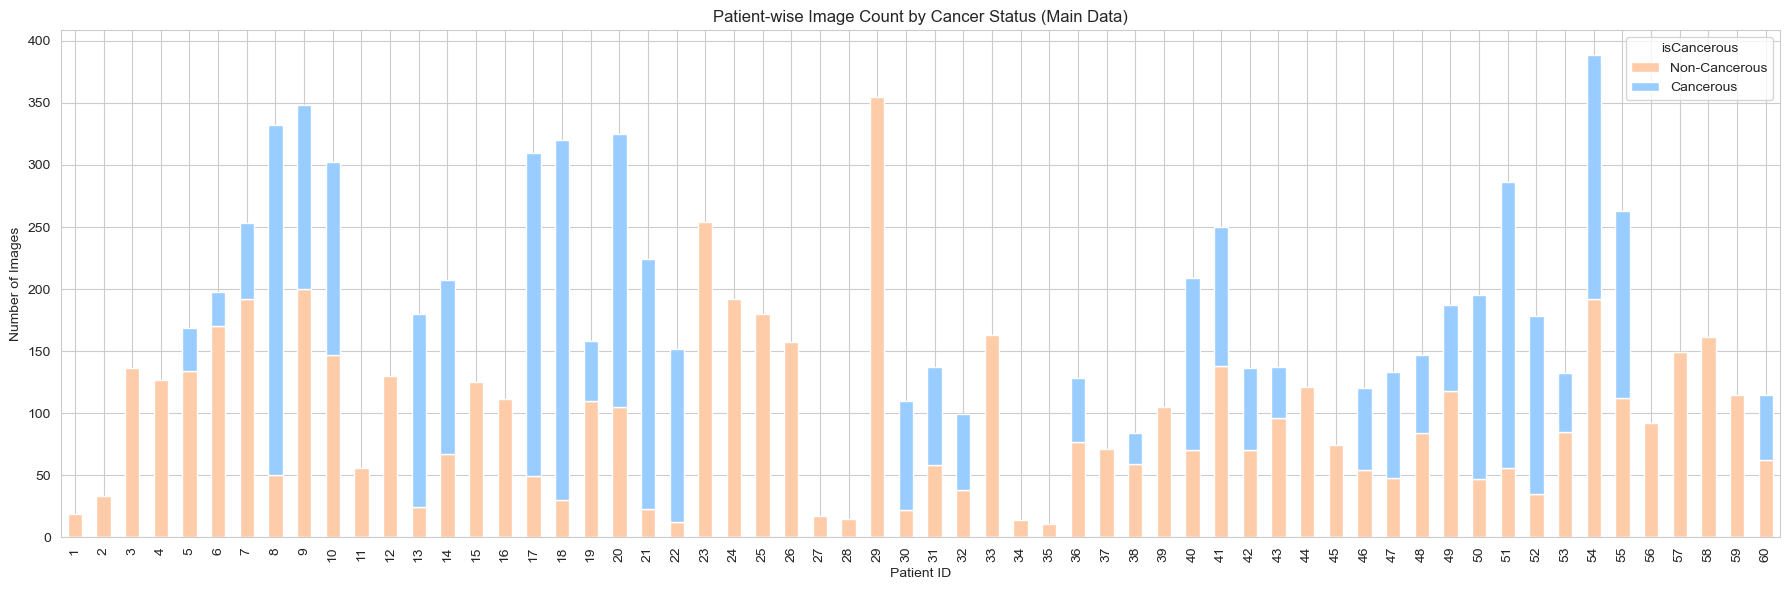

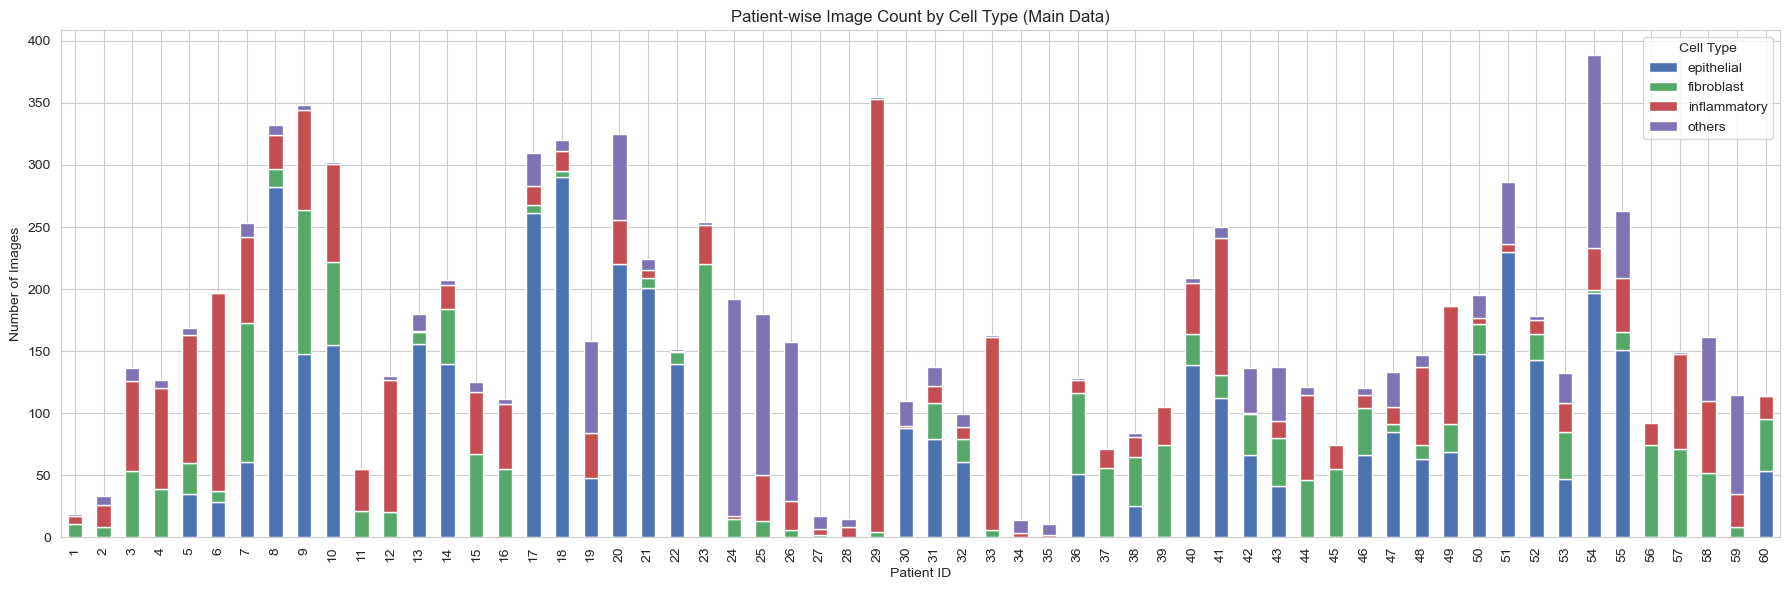

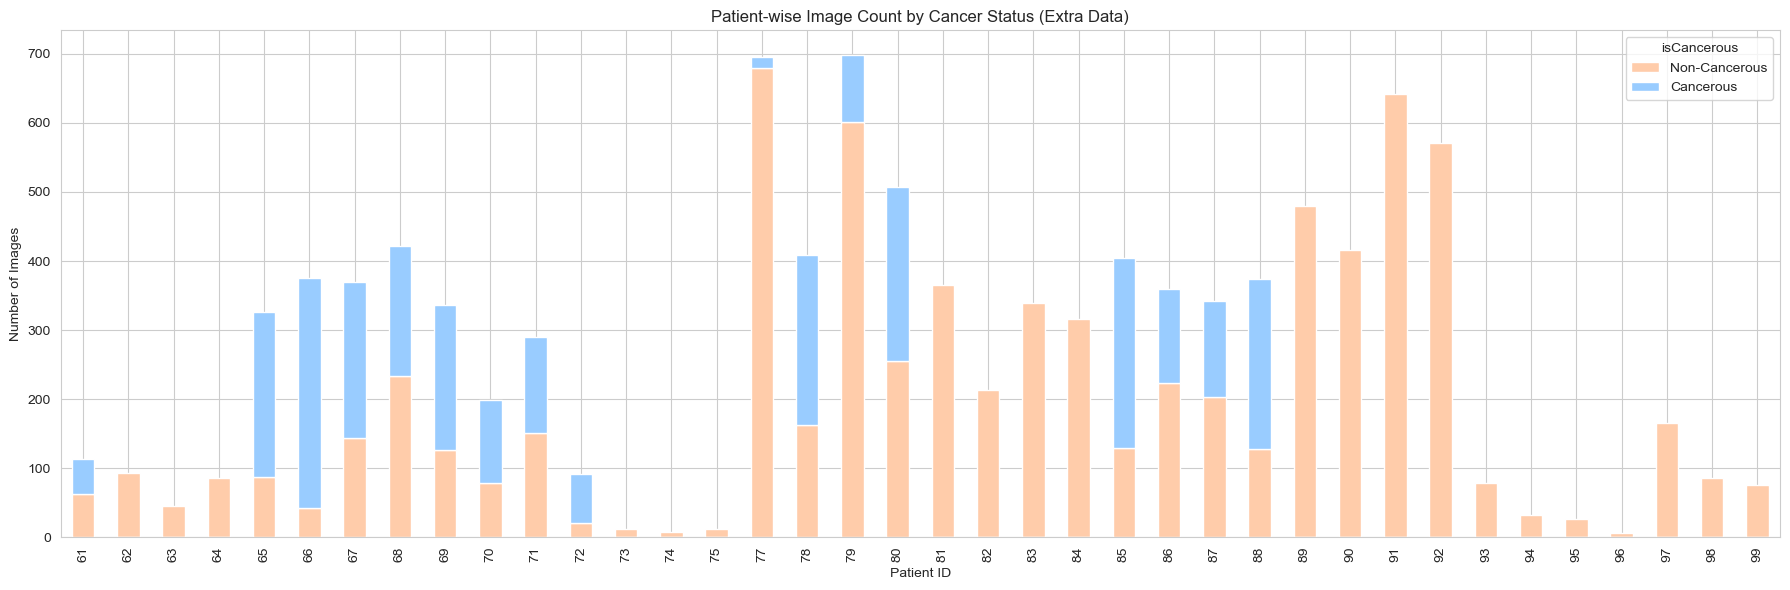

Image Pixel Value Range:
Min pixel value: 4
Max pixel value: 255


In [15]:
sns.set_style('whitegrid')

#-----------------------------------------class imbalance:isCancerous-main and extra----------------------------------#
fig, axes = plt.subplots(1, 2, figsize=(12, 4), sharey=True)

#main data...
sns.countplot(ax=axes[0], data=main_data, x='isCancerous', hue='isCancerous', palette='pastel', legend=False)
axes[0].set_title('Distribution: Cancerous vs Non-Cancerous (Main)')
axes[0].set_xlabel('isCancerous (0 = Non-cancerous, 1 = Cancerous)')
axes[0].set_ylabel('Number of Cells')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Non-Cancerous', 'Cancerous'])


sns.countplot(ax=axes[1], data=extra_data, x='isCancerous', hue='isCancerous', palette='pastel', legend=False)
axes[1].set_title('Distribution: Cancerous vs Non-Cancerous (Extra)')
axes[1].set_xlabel('isCancerous (0 = Non-cancerous, 1 = Cancerous)')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Non-Cancerous', 'Cancerous'])

plt.tight_layout()
plt.show()

unique, counts = np.unique(main_data['isCancerous'].values, return_counts=True)
print("Class distribution (isCancerous) - Main Data:")
for cls, count in zip(unique, counts):
    percent = count / len(main_data) * 100
    label = 'Cancerous' if cls == 1 else 'Non-Cancerous'
    print(f"{label}: {count} samples ({percent:.2f}%)")
print()

unique_ext, counts_ext = np.unique(extra_data['isCancerous'].values, return_counts=True)
print("Class distribution (isCancerous) - Extra Data:")
for cls, count in zip(unique_ext, counts_ext):
    percent = count / len(extra_data) * 100
    label = 'Cancerous' if cls == 1 else 'Non-Cancerous'
    print(f"{label}: {count} samples ({percent:.2f}%)")
print()


#---------------------------------------class Imbalance: cellTypeName---------------------------------------#
plt.figure(figsize=(6,4))
sns.countplot(data=main_data, x='cellTypeName', hue='cellTypeName', 
              order=main_data['cellTypeName'].value_counts().index, palette='muted', legend=False)
plt.title('Distribution of Cell Types')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.xticks(rotation=45)
plt.show()


#print percentage for cellTypeName...
print("Class distribution (cellTypeName):")
cell_counts = Counter(main_data['cellTypeName'])
total = len(main_data)
for label, count in cell_counts.items():
    print(f"{label}: {count} samples ({count / total:.2%})")
print()


#------------------------------------ correlation: cellTypeName vs isCancerous ------------------------------------#
celltype_cancer_distribution = main_data.groupby(['cellTypeName', 'isCancerous']).size().unstack(fill_value=0)
celltype_cancer_distribution = celltype_cancer_distribution.reindex(main_data['cellTypeName'].value_counts().index)

plt.figure(figsize=(6, 4))
celltype_cancer_distribution.plot(kind='bar', stacked=True, color=['#ffccaa', '#99ccff'], figsize=(6, 4))
plt.title('Cancerous vs Non-Cancerous Distribution by Cell Type')
plt.xlabel('Cell Type')
plt.ylabel('Number of Cells')
plt.legend(['Non-Cancerous', 'Cancerous'], title='isCancerous')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("Cell Type vs isCancerous Distribution:")
print(celltype_cancer_distribution)


#-------------------------------------patient ditsribution:main------------------------------------#
pivot_cancer = main_data.groupby(['patientID', 'isCancerous']).size().unstack(fill_value=0)
pivot_cancer.plot(kind='bar', stacked=True, figsize=(18,6), color=['#ffccaa', '#99ccff'])
plt.title('Patient-wise Image Count by Cancer Status (Main Data)')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.legend(['Non-Cancerous', 'Cancerous'], title='isCancerous')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


pivot_celltype = main_data.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
pivot_celltype.plot(kind='bar', stacked=True, figsize=(18,6), color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])
plt.title('Patient-wise Image Count by Cell Type (Main Data)')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.legend(title='Cell Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#------------------------------------patient distribution:extra-------------------------------------#
pivot_df = extra_data.groupby(['patientID', 'isCancerous']).size().unstack(fill_value=0)
pivot_df.plot(kind='bar', stacked=True, figsize=(18,6), color=['#ffccaa', '#99ccff'])

plt.title('Patient-wise Image Count by Cancer Status (Extra Data)')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.legend(['Non-Cancerous', 'Cancerous'], title='isCancerous')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


#---------------------------------------image range check--------------------------------------------#
sample_image = np.array(Image.open(os.path.join(image_folder, image_files[0])))
print("Image Pixel Value Range:")
print("Min pixel value:", sample_image.min())
print("Max pixel value:", sample_image.max())



## Exploratory Data Analysis (EDA)


#### Class Distribution: `isCancerous`
- **Main dataset**:
  - Non-cancerous: 5,817 (58.78%)
  - Cancerous: 4,079 (41.22%)
- **Extra dataset**:
  - Non-cancerous: 7,394 (71.21%)
  - Cancerous: 2,990 (28.79%)
- Extra data is more imbalanced toward non-cancerous samples.


#### Class Distribution: `cellTypeName` (Main Data Only)
- Epithelial: 4,079 (41.22%)
- Inflammatory: 2,543 (25.70%)
- Fibroblast: 1,888 (19.08%)
- Others: 1,386 (14.01%)
- Moderate imbalance; 'others' underrepresented.

Class distribuition for targets is not great and if does not get addressed it would impact all the models. The dominant class is Epithelial whereas the minority is the 'Others' Class.


#### Correlation: Cell Type vs Cancer
- All cancerous samples are epithelial.
- Other cell types are exclusively non-cancerous.
- Model may overfit epithelial ↔ cancerous link.


#### Patient-wise Cancer Distribution (Main)
- Some patients contribute >300 patches.
- Patients mostly contribute to one class (cancerous or non-cancerous).


#### Patient-wise Cell Type Distribution (Main)
- Epithelial dominates, especially in cancerous cases.
- 'Others' underrepresented.
- Some patients show mixed cell types; others show dominance.


#### Patient-wise Cancer Distribution (Extra)
- Heavily skewed toward non-cancerous.
- Fewer patients with cancerous patches.
- Could bias semi-supervised learning.


#### Image Pixel Value Range
- Min: 4, Max: 255
- Standard 8-bit format; suitable for normalization.







## Data Preprocessing

- As observed in the EDA we should normalize images so pixels are between 0 and 1. Do by dividing each image by 255. Ensures all images are within same range so bias is lessened.

- Encoding Categorical variables - isCancerous (already binary). Cell type categories Epithelial, Inflammatory, Fibroblast, Others needs to be encoded. Use the LabelEncoder followed with to_categorical to to make it one-hot encoded. So that model can correctly interpret categorical values.

In addition to this there are other preprocessing techniques involved such as handling class imbalance and Image augmentation which we will discuss later.

In [18]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

def load_images(image_names, image_dir='patch_images'):
    images = []
    for name in image_names:
        img_path = os.path.join(image_dir, name)
        img = Image.open(img_path)
        img_array = np.array(img) / 255.0  # normalize to [0,1]
        images.append(img_array)
    return np.array(images)


X_train_binary = load_images(X_train_binary)
X_val_binary = load_images(X_val_binary)
X_test_binary = load_images(X_test_binary)

X_train_multi = load_images(X_train_multi)
X_val_multi = load_images(X_val_multi)
X_test_multi = load_images(X_test_multi)


# Multiclass: label encoding + one-hot
label_encoder = LabelEncoder()
y_train_multi_enc = label_encoder.fit_transform(y_train_multi)
y_val_multi_enc = label_encoder.transform(y_val_multi)
y_test_multi_enc = label_encoder.transform(y_test_multi)

y_train_multi = to_categorical(y_train_multi_enc)
y_val_multi = to_categorical(y_val_multi_enc)
y_test_multi = to_categorical(y_test_multi_enc)

#added for Random Forest...
X_train_flat = X_train_multi.reshape(X_train_multi.shape[0], -1)
X_val_flat = X_val_multi.reshape(X_val_multi.shape[0], -1)
X_test_flat = X_test_multi.reshape(X_test_multi.shape[0], -1)

# ---------- Summary ----------
print("Binary Labels (one-hot):", y_train_binary.shape)
#print("Multiclass Labels (one-hot):", y_train_multi.shape)
print("Multiclass label mapping:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))
print("Image input shape example:", X_train_binary.shape[1:])


Binary Labels (one-hot): (7073,)
Multiclass label mapping: {'epithelial': 0, 'fibroblast': 1, 'inflammatory': 2, 'others': 3}
Image input shape example: (27, 27, 3)


#### Hyperparameters
Settings we tune to improve learning and generalization. Used dropout and L2 regularization in all enhanced models. Will tune L2 values to explore regulaization.

#### Learning Rate
Set to 0.001 with `ReduceLROnPlateau` to lower it when validation loss plateaus.

#### L2 Regularization
Penalizes large weights to reduce overfitting. Tested values from 0.00001 to 1.0.

#### Batch Size
Fixed at 32 for consistency and efficient hardware use.

#### Epochs
Trained for 100 epochs to balance learning and resource limits.

#### Optimizer
Used Adam for efficient, balanced optimization over alternatives like SGD.

#### Number of Layers
Controls model depth, affecting underfitting and overfitting.

#### Activation Function
Used ReLU (hidden layers), Sigmoid (binary), Softmax (multiclass).


### Helper Cell

This helper cell belows allows us to easily tune some parameters such as epochs, batch size and learning rate. 


In [21]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
# Input shape stays consistent to image size
input_shape = (27,27,3)

# Hyper Parameters: TUNE HERE
batch_size = 32
epochs = 100
lr = 0.001 # learning rate

#### SEED 
The cell below sets a seed so we can try to repeat consistent results. However due to hardware differences each time total consistency is not achieved.

In [23]:
import random
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input
from sklearn.metrics import classification_report

SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [25]:
"""
The function below visualizes the training process of a deep learning model by plotting the learning curves. 
It extracts training and validation accuracy along with loss values.
"""

def plot_learning_curve(history, metric_name='accuracy'):
    import matplotlib.pyplot as plt

    history_dict = history.history
    train_acc = history_dict.get(metric_name)
    val_acc = history_dict.get(f'val_{metric_name}')
    train_loss = history_dict.get('loss')
    val_loss = history_dict.get('val_loss')

    if train_acc is None or val_acc is None:
        raise ValueError(f"Metric '{metric_name}' or 'val_{metric_name}' not found in history.")

    plt.figure(figsize=(10, 4))

    plt.subplot(1, 2, 1)
    plt.plot(train_acc, label='Train')
    plt.plot(val_acc, label='Validation')
    plt.title(f'{metric_name.capitalize()} over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name.capitalize())
    plt.legend()

    # Loss Plot
    plt.subplot(1, 2, 2)
    plt.plot(train_loss, label='Train')
    plt.plot(val_loss, label='Validation')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout(pad=3.0)
    plt.show()


In [27]:
from sklearn.metrics import classification_report

"""
This function computes the classification reprot using sklearn.metrics.classification_report() and shows:

Precision, Recall, and F1-score per class...
Overall aggregated metrics like macro average, weighted average, and accuracy...
By separating these into two side by side bar plots, we can see:

Which classes the model perfrms well on and
Where it may be biased toward dominant classes
This is especialy useful in multi-class settings with class imbalance.

"""

def plot_classification_metrics(y_true, y_pred, label_names=None, model_name="Model"):

    report = classification_report(y_true, y_pred, target_names=label_names, output_dict=True, zero_division=0)
    report_df = pd.DataFrame(report).transpose()

    class_metrics = report_df.iloc[:-3, :][['precision', 'recall', 'f1-score']]
    overall_metrics = report_df.loc[['accuracy', 'macro avg', 'weighted avg'], ['precision', 'recall', 'f1-score']]

    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    class_metrics.plot(kind='bar', ax=axes[0], legend=True)
    axes[0].set_title(f"{model_name} - Per-Class Metrics")
    axes[0].set_ylabel("Score")
    axes[0].set_ylim(0, 1.1)
    axes[0].tick_params(axis='x', rotation=45)
    axes[0].grid(axis='y')

    overall_metrics.plot(kind='bar', ax=axes[1], legend=True, color=['tab:blue', 'tab:orange', 'tab:green'])
    axes[1].set_title(f"{model_name} - Overall Metrics")
    axes[1].set_ylabel("Score")
    axes[1].set_ylim(0, 1.1)
    axes[1].tick_params(axis='x', rotation=0)
    axes[1].grid(axis='y')
    
    plt.tight_layout()
    plt.show()



In [29]:
"""
This function generates a labled confusion matrix using sklearn.metrics.confusion_matrix() 
and ConfusionMatrixDisplay(). 

It helps us understand:

How often each class is corectly classified(diagonal)..
Which classes are most confused with one another(offdiagonal)..
Whether the model completely misses any class(rows with zero on diagonal)..
We used this plot to check whether models like MLP, CNN, and Random Forest are learning features, 
especially for classes like others in the multiclass cell type classification.

"""

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_confusion_matrix(y_true, y_pred, label_names=None, model_name="Model", cmap="Blues"):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_names)

    fig, ax = plt.subplots(figsize=(5, 4))
    disp.plot(ax=ax, cmap=cmap, xticks_rotation=45)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()
    plt.show()

# Model Building and Training

We are required to to build at least two models capable of predicting the binary classification and multi-class classification of cell type. 

We will be using a Multilayer Perceptron (MLP) for both isCancerous and Cell types for the base model of this experiment.

The metrics used in this investigation are explained in the appendix.

## Multilayer Perceptron (MLP)
An MLP (Multilayer Perceptron) is a simple model. Despite its simplicity, it can get non-linear patterns using activation functions, making it an efficient baseline.

Consists of layers. Data flows forward through the network (feedforward), and the model learns by adjusting weights using backpropagation, which minimizes prediction errors based on the computed loss.

While useful as a baseline, we will later explore more advanced models better suited to our task.

### Base-Model for Cancerous Cell Classification

For our baseline model, we use a simple MLP. This architecture makes a balance complex enough to capture patterns, but simple enough to serve as a fair baseline. It’s compiled with the Adam optimizer and binary_crossentropy loss. No callbacks or regularization are used.

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,153 (2.26 MB)

 Trainable params: 593,153 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.5871 - loss: 0.7447 - val_accuracy: 0.6600 - val_loss: 0.5413
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7580 - loss: 0.5037 - val_accuracy: 0.8561 - val_loss: 0.3632
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8003 - loss: 0.4536 - val_accuracy: 0.8762 - val_loss: 0.3401
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8102 - loss: 0.4285 - val_accuracy: 0.8762 - val_loss: 0.3388
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8092 - loss: 0.4318 - val_accuracy: 0.8754 - val_loss: 0.3308
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8075 - loss: 0.4305 - val_accuracy: 0.8738 - val_loss: 0.3506
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8117 - loss: 0.4238 - val_accuracy: 0.8762 - val_loss: 0.3359
Epoch 8/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8161 - loss: 0.4224 - val_accu

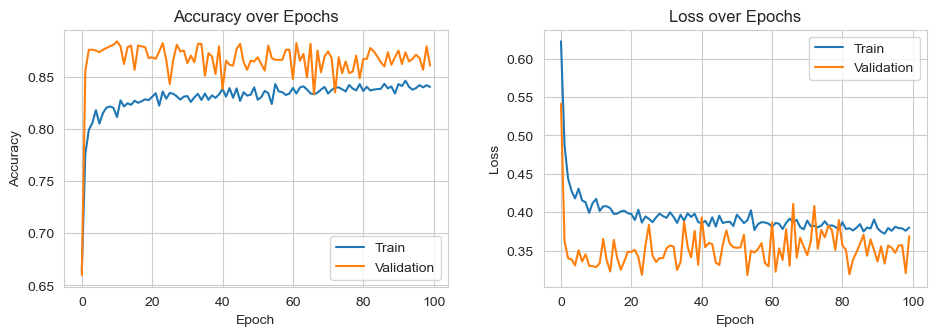

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 836us/step


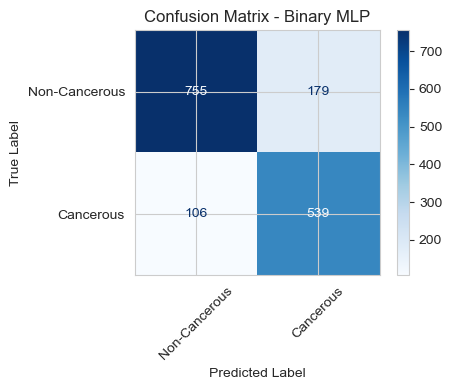

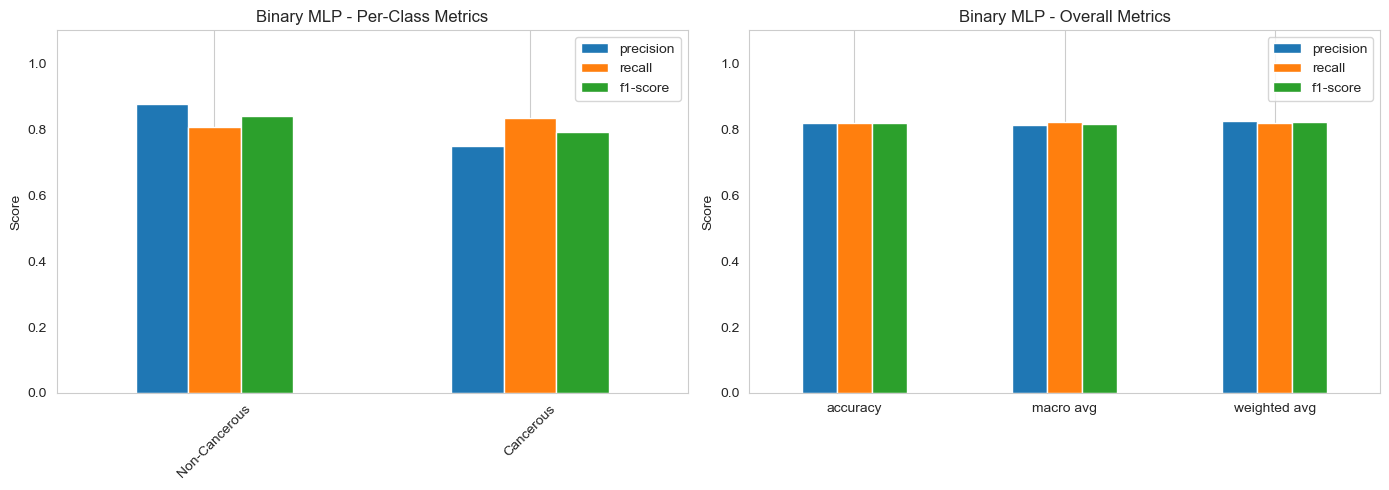


==== Binary MLP - Classification Report ====
               precision    recall  f1-score   support

Non-Cancerous       0.88      0.81      0.84       934
    Cancerous       0.75      0.84      0.79       645

     accuracy                           0.82      1579
    macro avg       0.81      0.82      0.82      1579
 weighted avg       0.83      0.82      0.82      1579



In [32]:
from sklearn.metrics import classification_report
model_binary_mlp = Sequential([
    Input(shape=input_shape),
    Flatten(),          
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')            
])

# Compile
model_binary_mlp.compile(
    optimizer=Adam(learning_rate=lr),
    loss='binary_crossentropy',           
    metrics=['accuracy']
)

# Summary
model_binary_mlp.summary()

history_base_binary = model_binary_mlp.fit(
    X_train_binary, y_train_binary,
    validation_data=(X_val_binary, y_val_binary),
    epochs=epochs,
    batch_size=batch_size,
)

test_loss, test_acc = model_binary_mlp.evaluate(X_test_binary, y_test_binary, verbose=0)
print(f'Binary-class Test accuracy: {test_acc:.4f}')

plot_learning_curve(history_base_binary, metric_name='accuracy')

y_pred_probs_binary = model_binary_mlp.predict(X_test_binary)
y_pred_binary = (y_pred_probs_binary > 0.5).astype(int).flatten()

plot_confusion_matrix(
    y_true=y_test_binary,
    y_pred=y_pred_binary,
    label_names=["Non-Cancerous", "Cancerous"],
    model_name="Binary MLP"
)


plot_classification_metrics(
    y_true=y_test_binary,
    y_pred=y_pred_binary,
    label_names=["Non-Cancerous", "Cancerous"],
    model_name="Binary MLP"
)
print(f"\n==== Binary MLP - Classification Report ====")
print(classification_report(y_test_binary, y_pred_binary, target_names=["Non-Cancerous", "Cancerous"], zero_division=0))

### **Independent Model Evaluation for Base-Model isCancerous**

The base MLP model achieved a final accuracy of 81.95%, with validation accuracy slightly outperforming training accuracy suggesting good generalization without signs of overfitting or data leakage.

Loss and accuracy curves confirm stable training, with validation loss consistently lower than training loss. Precision, recall, and F1-score were around 84% per class and 80% overall, indicating balanced performance despte class imbalance.
The confusion matrix shows:
* 755 true negatives
* 539 true positives
* 179 false negatives
* 106 false positives

Overall, model demonstrates strong and consistent performance for cancer cell detection

### Base-Model for Cell Type Classification

Similarly to the binary classification model.

Since this is a multiclass problem with 4 classes. Replaced the loss function from binary_crossentropy to categorical_crossentropy for mutli-class classification.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_1 (Flatten)             │ (None, 2187)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 256)            │       560,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           516 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 593,540 (2.26 MB)

 Trainable params: 593,540 (2.26 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.3718 - loss: 1.5418 - val_accuracy: 0.4040 - val_loss: 1.2148
Epoch 2/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4097 - loss: 1.2250 - val_accuracy: 0.5211 - val_loss: 1.0814
Epoch 3/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4630 - loss: 1.1758 - val_accuracy: 0.4522 - val_loss: 1.2676
Epoch 4/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.4822 - loss: 1.1639 - val_accuracy: 0.5893 - val_loss: 1.0070
Epoch 5/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4866 - loss: 1.1420 - val_accuracy: 0.5797 - val_loss: 1.0023
Epoch 6/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4834 - loss: 1.1509 - val_accuracy: 0.6064 - val_loss: 0.9972
Epoch 7/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4885 - loss: 1.1374 - val_accuracy: 0.6049 - val_loss: 0.9939
Epoch 8/100
213/213 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.4897 - loss: 1.1395 - val_accu

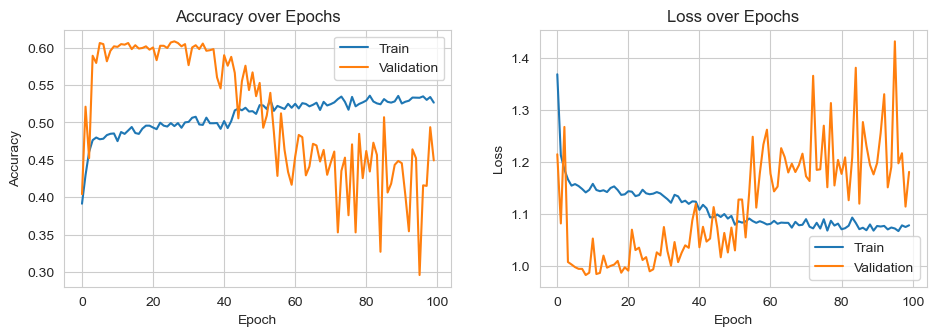

55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 855us/step


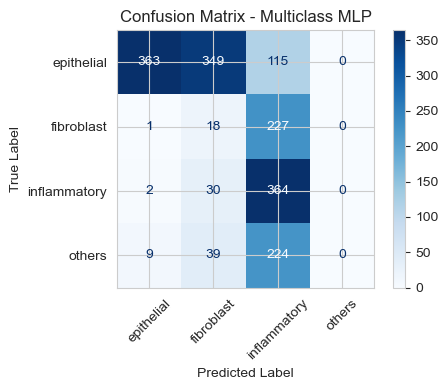

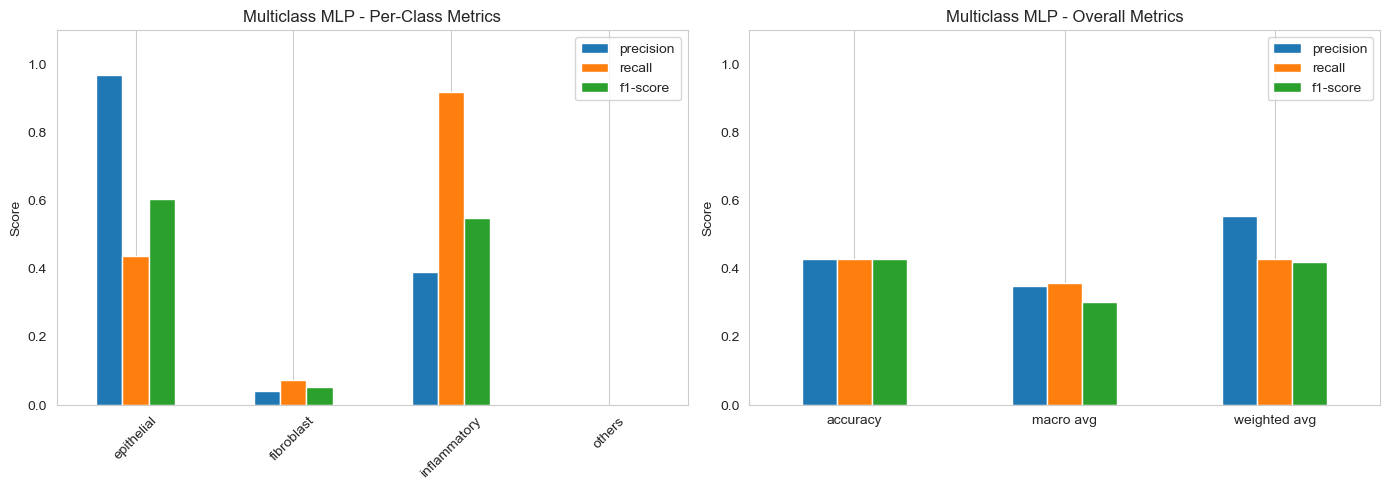


==== Multiclass MLP - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.97      0.44      0.60       827
  fibroblast       0.04      0.07      0.05       246
inflammatory       0.39      0.92      0.55       396
      others       0.00      0.00      0.00       272

    accuracy                           0.43      1741
   macro avg       0.35      0.36      0.30      1741
weighted avg       0.55      0.43      0.42      1741



In [35]:
num_classes = 4
model_multi_mlp = Sequential([
    Flatten(input_shape=input_shape),      
    Dense(256, activation='relu'),
    Dropout(0.3),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')  
])

# Compile
model_multi_mlp.compile(
    optimizer=Adam(learning_rate=lr),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# Summary
model_multi_mlp.summary()

# Fit
history_base_multi = model_multi_mlp.fit(
    X_train_multi, y_train_multi,
    validation_data=(X_val_multi, y_val_multi),
    epochs=epochs,
    batch_size=batch_size
)

# Evaluate
test_loss_multi, test_acc_multi = model_multi_mlp.evaluate(X_test_multi, y_test_multi, verbose=0)
print(f'Multi-class Test accuracy: {test_acc_multi:.4f}')
plot_learning_curve(history_base_multi, metric_name='accuracy')

y_pred_probs_multi = model_multi_mlp.predict(X_test_multi)
y_pred_multi = np.argmax(y_pred_probs_multi, axis=1)
y_true_multi = np.argmax(y_test_multi, axis=1)


plot_confusion_matrix(
    y_true=y_true_multi,
    y_pred=y_pred_multi,
    label_names=label_encoder.classes_,
    model_name="Multiclass MLP"
)


plot_classification_metrics(
    y_true=y_true_multi,
    y_pred=y_pred_multi,
    label_names=label_encoder.classes_, 
    model_name="Multiclass MLP"
)

print(f"\n==== Multiclass MLP - Classification Report ====")
print(classification_report(y_true_multi, y_pred_multi, target_names=label_encoder.classes_, zero_division=0))


## **Independent Model Evaluation for Base-Model Cell-type**

The base model performs poorly on multiclass cell type task, with only 42% accuracy and 40% validation accuracy, showing weak generalization. Learning curves show rising loss above 1.0, suggesting model struggles to learn and may be overfitting or not unsuited for this task.

The confusion matrix reveals that model mostly predicts epithelial cells, with 363 true positives but high false positives e.g., 349 fibroblast and 115 inflammatory cells misclassified as epithelial. Inflammatory cells are predicted slightly better.

This imbalance is shown in class metrics, where epithelial and inflammatory classes have higher precision/recall. The macro average shows poor performance, while weighted average appears better due to class imbalance.

These results highlight need to address class imbalance for effective multiclass cell type classification.

### Helper Cell for Model optimization
#### Callbacks
Callbacks help control training process. We use two key Keras callbacks:
* ReduceLROnPlateau: Lowers learning rate when the val loss plataues
* EarlyStopping: Stops training at earlier epoch if model not improving.

#### Addressing Class Imbalance Using Class Weights
Class imbalance especially in multi class. 'Others' type underrepresented. Class weights adjusts this imbalance and allows balance for model to improve generalization


#### Image Augmentation
Applied to training data using `ImageDataGenerator`: random rotations (≤40°), shifts, zooms, shears, and flips to enhance generalization and help model extract important features in images.

#### Research on class imbalance
SMOTE explored but rejected as generates synthetic vector samples which can lead to unrealistic images and reduced model performance. 

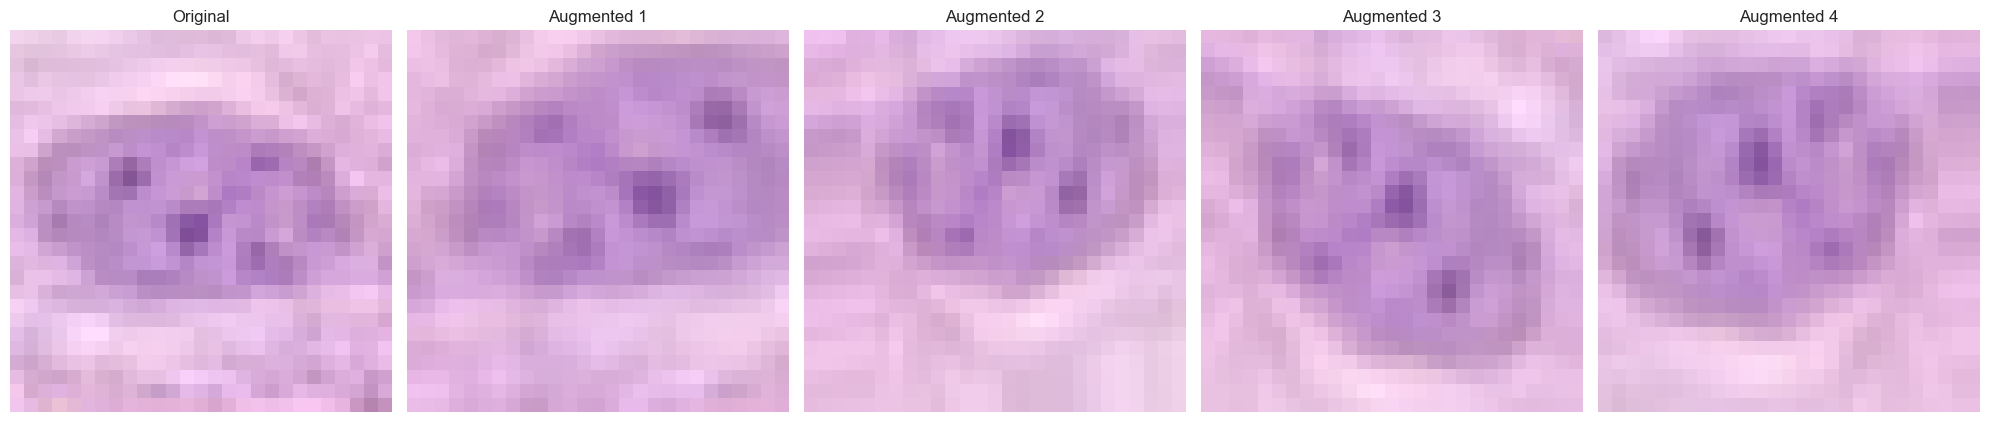

In [38]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras import Input

#callbacks -> EarlyStopping + ReduceLROnPlateau..
callbacks = [
    EarlyStopping(monitor='val_loss', 
                  patience=10, 
                  restore_best_weights=True),
    ReduceLROnPlateau(monitor='val_loss', 
                      patience=5, 
                      cooldown=0, 
                      factor=0.5, 
                      min_lr=1e-6)
]


#class weights for binary..
class_weights = compute_class_weight(class_weight='balanced',
                                     classes=np.unique(y_train_binary), 
                                     y=y_train_binary)
class_weights_dict_binary = dict(enumerate(class_weights))

#class weights for multi..
y_train_int = np.argmax(y_train_multi, axis=1)
class_weights = compute_class_weight(class_weight='balanced', 
                                     classes=np.unique(y_train_int),
                                     y=y_train_int)
class_weights_dict_multi = dict(enumerate(class_weights))


#Image augmentation..
train_aug = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.15,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
val_test_aug = ImageDataGenerator()

#print orginal image + augmented image..
sample_image = X_train_binary[0]
sample_image_batch = sample_image.reshape((1,) + sample_image.shape)

aug_iter = train_aug.flow(sample_image_batch, batch_size=1)
augmented_imgs = [next(aug_iter)[0] for _ in range(4)]

titles = ["Original", "Augmented 1", "Augmented 2", "Augmented 3", "Augmented 4"]
images = [sample_image] + augmented_imgs

plt.figure(figsize=(20, 5))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(np.clip(images[i], 0, 1))
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()



train_generator_binary = train_aug.flow(X_train_binary, y_train_binary, batch_size=batch_size, shuffle=True, seed=SEED)
train_generator_multi = train_aug.flow(X_train_multi, y_train_multi, batch_size=batch_size, shuffle=True, seed=SEED)

val_generator_binary = val_test_aug.flow(X_val_binary, y_val_binary, batch_size=batch_size, shuffle=False)
test_generator_binary = val_test_aug.flow(X_test_binary, y_test_binary, batch_size=batch_size, shuffle=False)

val_generator_multi = val_test_aug.flow(X_val_multi, y_val_multi, batch_size=batch_size, shuffle=False)
test_generator_multi = val_test_aug.flow(X_test_multi, y_test_multi, batch_size=batch_size, shuffle=False)


# Model Enhancement
While the Multilayer Perceptron(MLP) serves as a solid baseline for both binary(isCancerous) and multiclass(cellTypeName) classification tasks,it treats image data as flat vectors and does not capture spatial relationships between pixels. 

## Convolutional Neural Network(CNN + MLP)
To address the limitations of a simple MLP, we implemnted a hybrid CNN+MLP architecture. Unlike MLPs, which flatten image data and lose spatial information, CNNs use local filters and receptive fields to extract spatial features.

Convolutional layers capture lowlevel patterns(e.g., edges) and complex structures in deeper layers. MaxPooling reduces spatial dimensions while preserving key features, and Batch Normalization stabilizes training.

The extracted features are then passed to fully connected MLP layers fr classification. This two stage setup CNN for feature extraction, MLP for classification achieves better generalization than MLP alone. We also deepened the network and expanded the dense layer to handle more complex patterns, resulting in improved accuracy.


### CNN+MLP for Cancerous Cell Classification


### No Regularization for Cancerous Cell Classification

We first implemented a CNN+MLP model without Dropout or L2 regularization to evaluate its raw learning capacity. The architecture includes convolutional layers with Batch Normalization and MaxPooling followed by a dense layer for binary classification.

Despite the absence of regularization, Batch Normalization was used to stabilize and speed up training. We used **ReLU** in hidden layers to avoid vanishing gradients and ensure efficient learning, and Sigmoid in the output layer for binary probability output. The model was trained with the **Adam** optimizer for its learning and fast convergence, and binary_crossentropy as the loss function standard for binary classification.

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


222/222 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.8228 - loss: 0.4620 - val_accuracy: 0.4325 - val_loss: 2.6600 - learning_rate: 0.0010
Epoch 2/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8663 - loss: 0.3169 - val_accuracy: 0.7926 - val_loss: 0.4910 - learning_rate: 0.0010
Epoch 3/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8847 - loss: 0.2805 - val_accuracy: 0.8497 - val_loss: 0.3461 - learning_rate: 0.0010
Epoch 4/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 8ms/step - accuracy: 0.8848 - loss: 0.2708 - val_accuracy: 0.8778 - val_loss: 0.2872 - learning_rate: 0.0010
Epoch 5/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8953 - loss: 0.2572 - val_accuracy: 0.8497 - val_loss: 0.3864 - learning_rate: 0.0010
Epoch 6/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8898 - loss: 0.2675 - val_accuracy: 0.9059 - val_loss: 0.2601 - learning_rate: 0.0010
Epoch 7/100
222/222 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.8891 - loss: 0.2681 - val_a

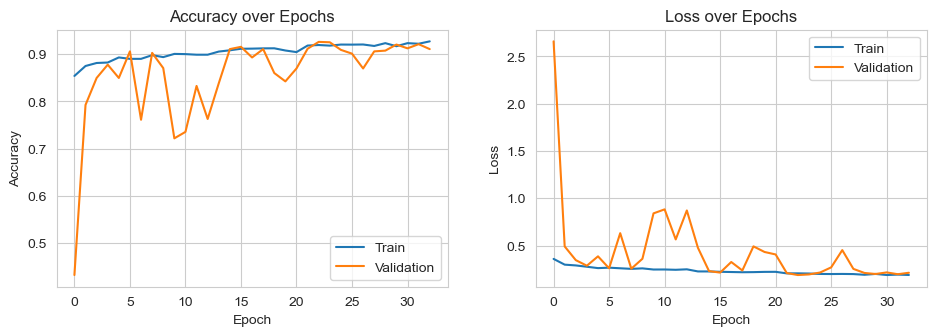

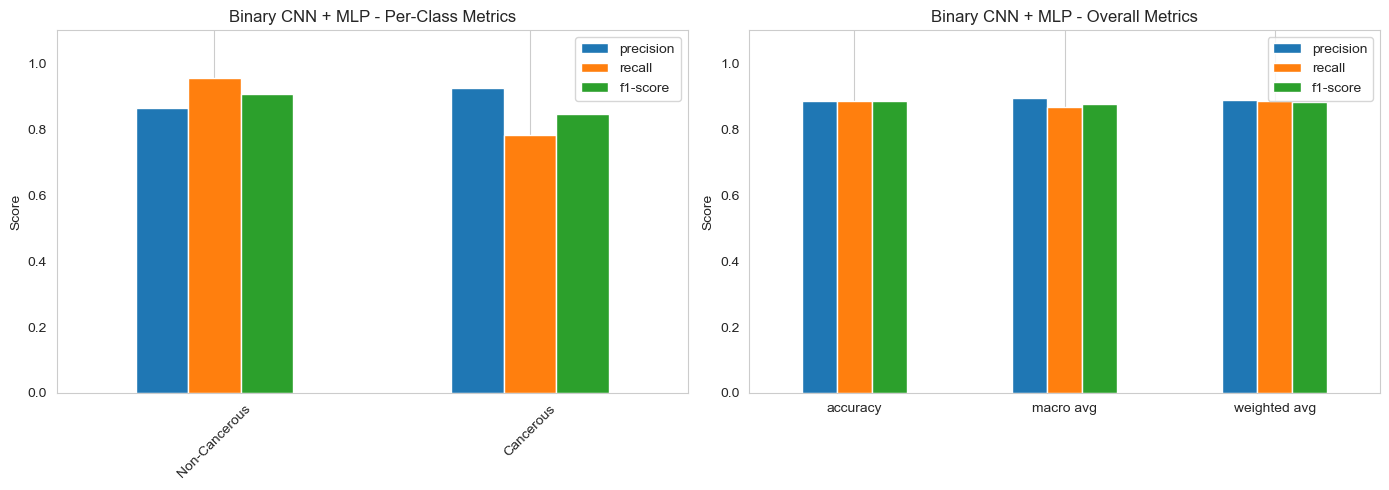

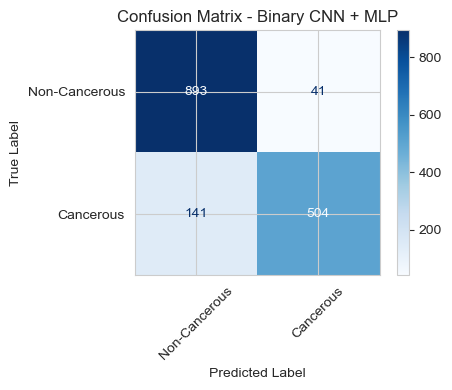


==== Binary CNN + MLP - Classification Report ====
               precision    recall  f1-score   support

Non-Cancerous       0.86      0.96      0.91       934
    Cancerous       0.92      0.78      0.85       645

     accuracy                           0.88      1579
    macro avg       0.89      0.87      0.88      1579
 weighted avg       0.89      0.88      0.88      1579



In [42]:
# CNN + MLP model for binary classification WITHOUT regularization...
model_binary_cnn = Sequential([
    #first convolutional block[extract local features with 32 filters...]
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),                    #normalize activations 
    MaxPooling2D(2, 2),                      #reduce spatial dimensions

    #second convolutional block[deeper features with 64 filters...]
    Conv2D(64, (3, 3), activation='relu'), 
    BatchNormalization(),     
    MaxPooling2D(2, 2), 

    #flatten the 3D feature into 1D vector for classification..
    Flatten(),

    #fully connected MLP layer to combine extratced features...
    Dense(128, activation='relu'), 
    #output layer[sigmoid for binary classification]
    Dense(1, activation='sigmoid')])



#use binary crossentropy for binary classification...
model_binary_cnn.compile(
    optimizer=Adam(learning_rate=lr),  #Adam optimizer....
    loss='binary_crossentropy',
    metrics=['accuracy'])

#train
history_binary_cnn = model_binary_cnn.fit(train_generator_binary,
                                          validation_data=val_generator_binary,
                                          epochs=epochs,
                                          callbacks=callbacks,              #EarlyStopping + ReduceLROnPlateau..
                                          class_weight=class_weights_dict_binary)  #handle class imbalance...

#evaluate
test_loss_binary, test_acc_binary = model_binary_cnn.evaluate(test_generator_binary, verbose=0)
print(f'Binary CNN + MLP(No Regularization) Test Accuracy: {test_acc_binary:.4f}')

#predict probabilities and convert to binary labels using 0.5 threshold...
y_pred_probs = model_binary_cnn.predict(test_generator_binary)
y_pred_labels = (y_pred_probs > 0.5).astype(int).flatten()

#plott training and validation accuracy/loss curves..
plot_learning_curve(history_binary_cnn)

plot_classification_metrics(
    y_true=y_test_binary,
    y_pred=y_pred_labels,
    label_names=["Non-Cancerous", "Cancerous"],
    model_name="Binary CNN + MLP"
)
plot_confusion_matrix(
    y_true=y_test_binary,
    y_pred=y_pred_labels,
    label_names=["Non-Cancerous", "Cancerous"],
    model_name="Binary CNN + MLP"
)

print(f"\n==== Binary CNN + MLP - Classification Report ====")
print(classification_report(y_test_binary, y_pred_labels, target_names=["Non-Cancerous", "Cancerous"], zero_division=0))


## Independant Evaluation for isCancerous CNN + MLP (No regularization)

The CNN model achieved strong results with average accuracy above 90% and test accuracy at 88.47% showing good generalization for cancer prediction.
The learning curve shows stable performance with a temporary dip between epochs 10-15, followed by recovery. This confirms the model is well-fitted.

The confusion matrix shows:
* 504 true positives (cancerous)
* 141 false negatives
* 41 false positives (non-cancerous)

Overall, the CNN clearly outperforms the MLP and proves to be a gud architecture for this binary classification task.

### Regularization for Cancerous Cell Classification

To imprve generalization and reduce overfitting, we enhanced the CNN+MLP model with L2 regularization and Dropout:
* L2 regularization was applied to both convolutional and dense layers to discourage overly complex weight patterns.
* Dropout (0.5) followed the dense layer, promoting redundancy by randomly deactivating neurons during training.
We tested L2 values from 0.00001 to 1.0, evalauting their impact on accuracy, loss, and learning rate trends. All other settings: optimizer, loss, class weights, and callbacks were kept consistent with the baseline for fair comparison.


Trying: L2=1e-05, Initial Learning Rate=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Learning Rate: 0.000125
Test Accuracy: 0.8277


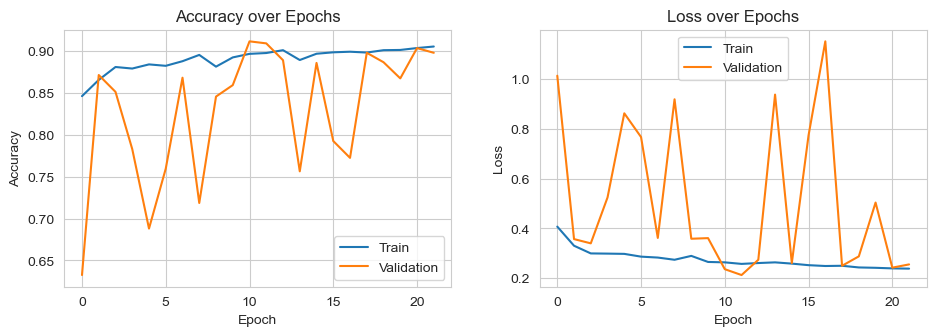

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


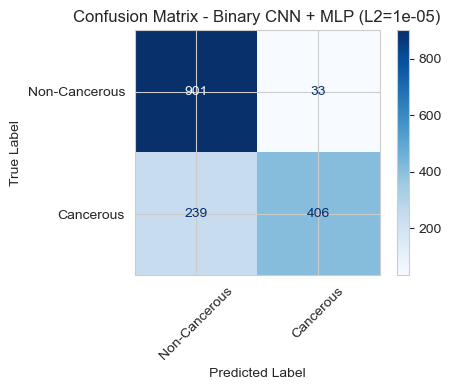

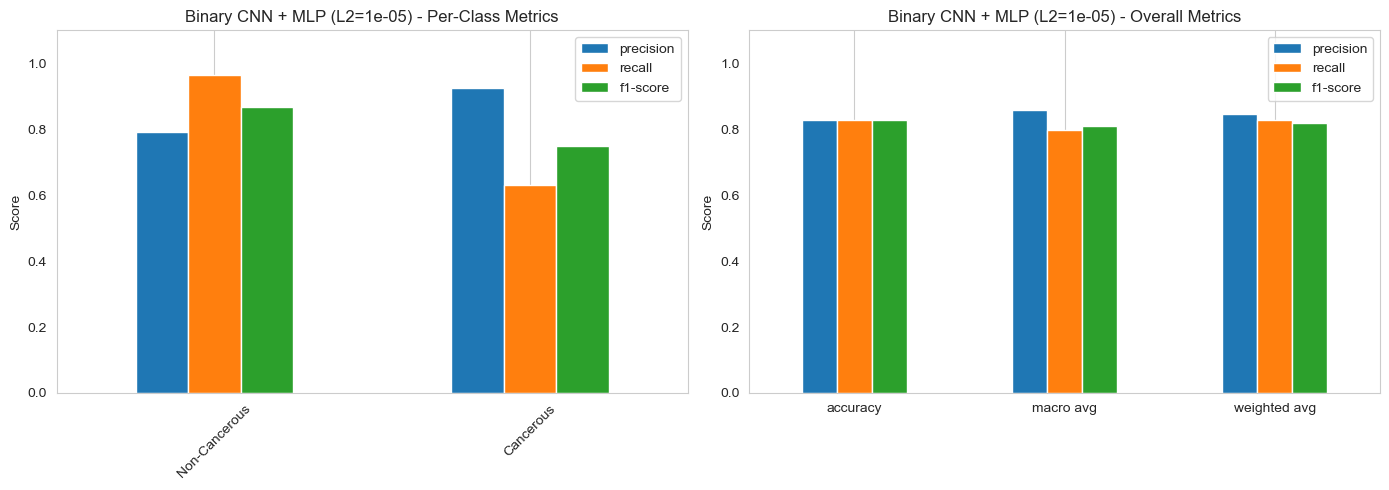


==== Binary CNN + MLP - Classification Report ====
               precision    recall  f1-score   support

Non-Cancerous       0.79      0.96      0.87       934
    Cancerous       0.92      0.63      0.75       645

     accuracy                           0.83      1579
    macro avg       0.86      0.80      0.81      1579
 weighted avg       0.85      0.83      0.82      1579


Trying: L2=5e-05, Initial Learning Rate=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Learning Rate: 0.000063
Test Accuracy: 0.8968


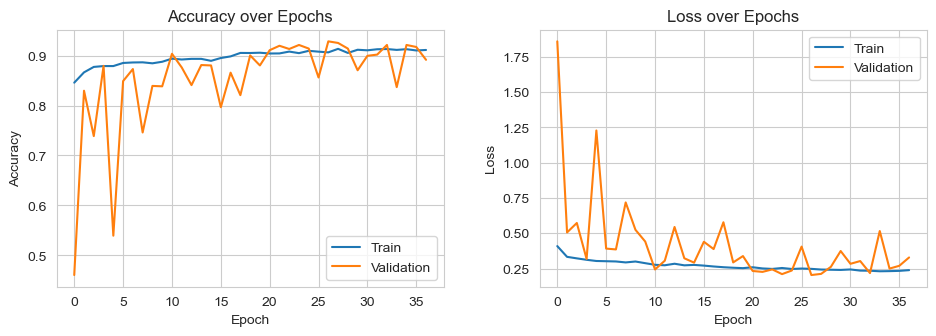

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


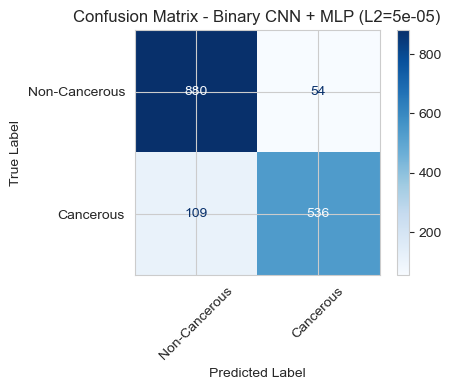

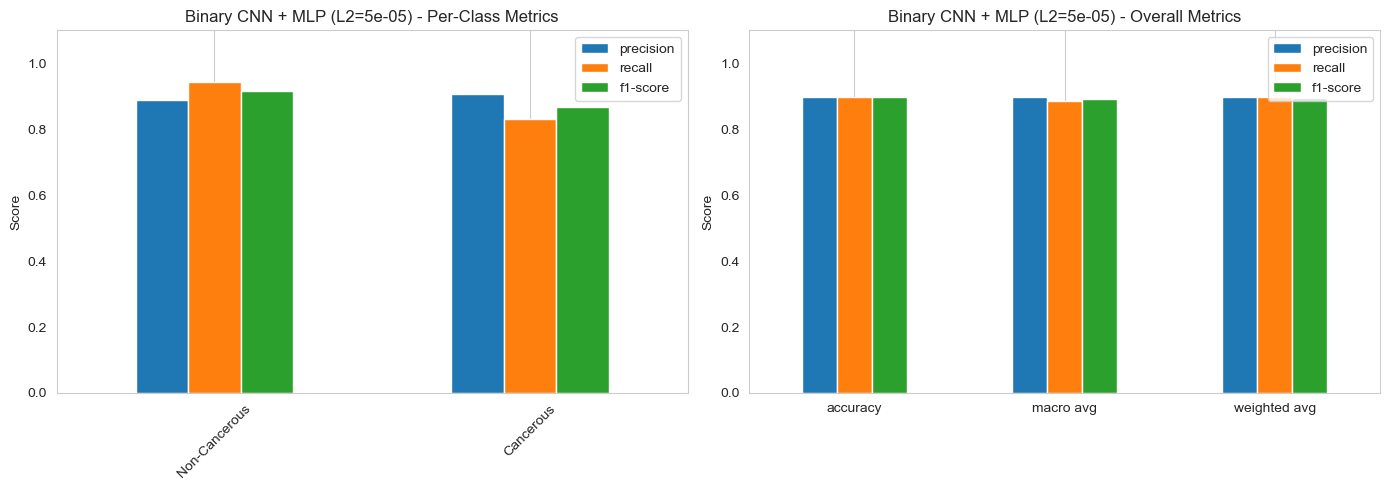


==== Binary CNN + MLP - Classification Report ====
               precision    recall  f1-score   support

Non-Cancerous       0.89      0.94      0.92       934
    Cancerous       0.91      0.83      0.87       645

     accuracy                           0.90      1579
    macro avg       0.90      0.89      0.89      1579
 weighted avg       0.90      0.90      0.90      1579


Trying: L2=0.0001, Initial Learning Rate=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Learning Rate: 0.000063
Test Accuracy: 0.8398


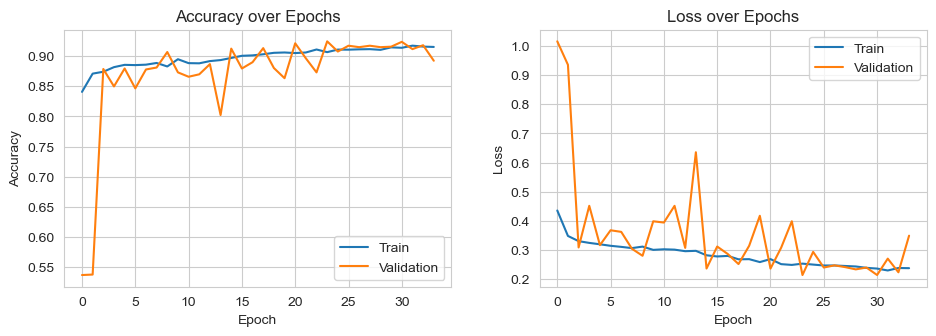

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


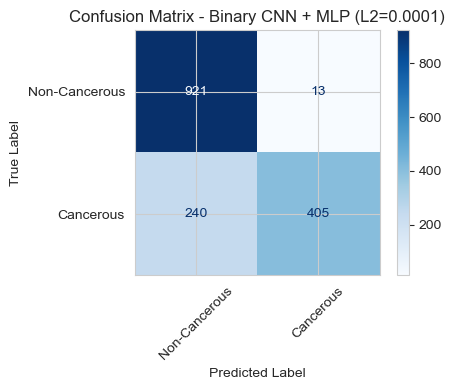

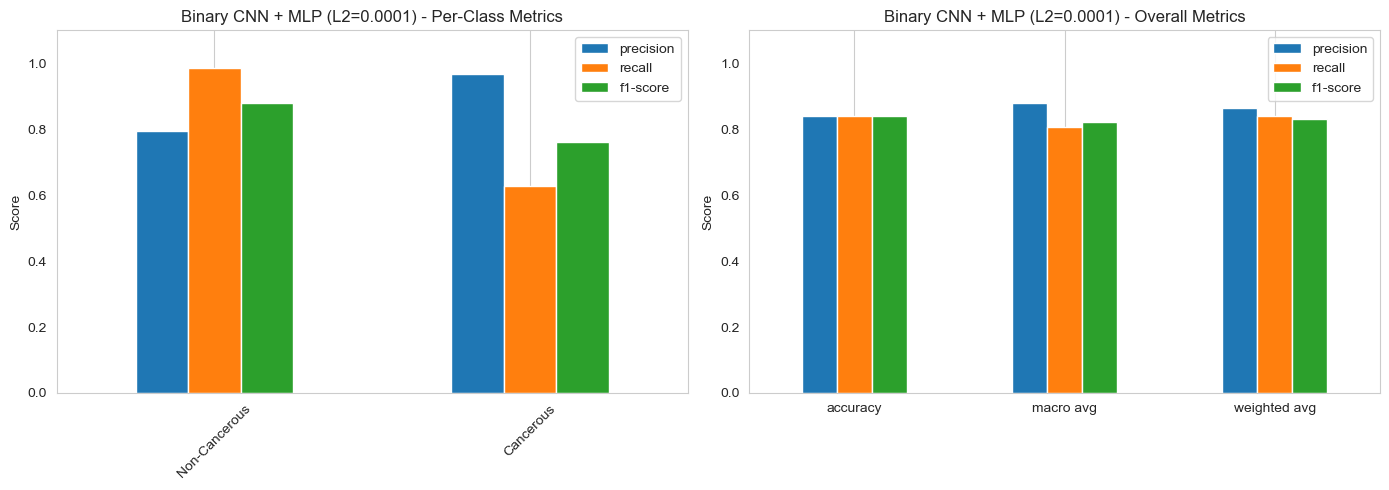


==== Binary CNN + MLP - Classification Report ====
               precision    recall  f1-score   support

Non-Cancerous       0.79      0.99      0.88       934
    Cancerous       0.97      0.63      0.76       645

     accuracy                           0.84      1579
    macro avg       0.88      0.81      0.82      1579
 weighted avg       0.87      0.84      0.83      1579


Trying: L2=0.0005, Initial Learning Rate=0.001


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Final Learning Rate: 0.000016
Test Accuracy: 0.9012


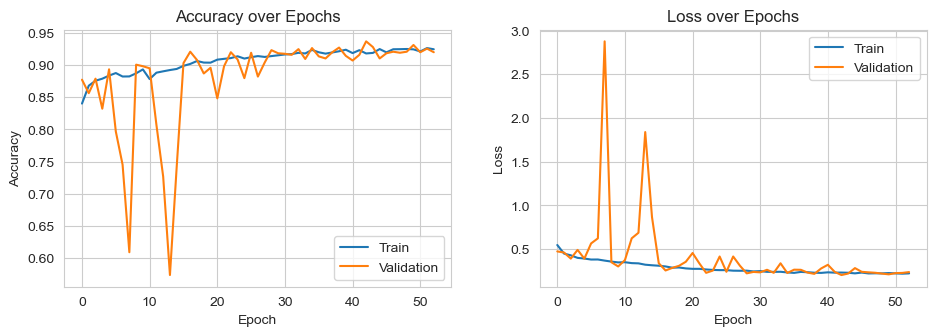

50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


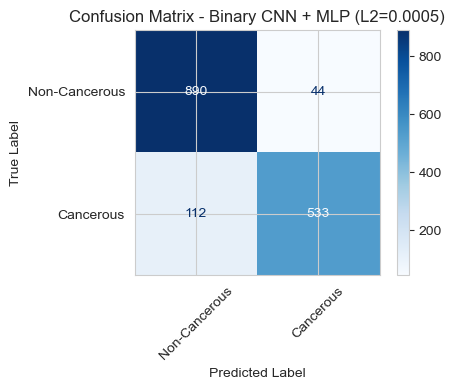

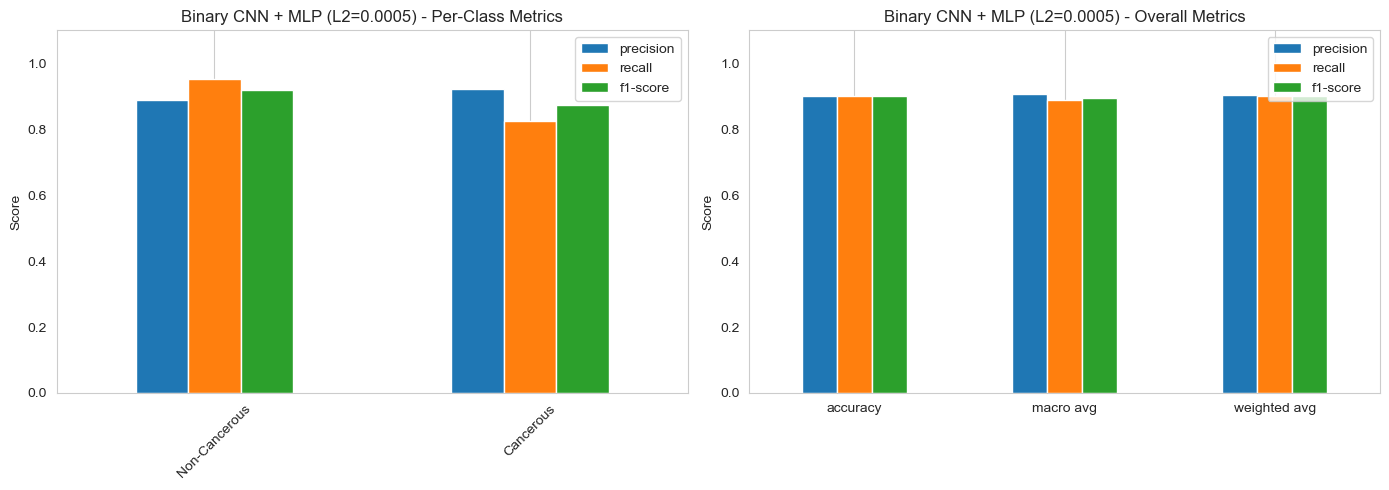


==== Binary CNN + MLP - Classification Report ====
               precision    recall  f1-score   support

Non-Cancerous       0.89      0.95      0.92       934
    Cancerous       0.92      0.83      0.87       645

     accuracy                           0.90      1579
    macro avg       0.91      0.89      0.90      1579
 weighted avg       0.90      0.90      0.90      1579



In [45]:
#l2_values = [0.0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]  #we have experimented all these..
l2_values_binary = [0.00001, 0.00005, 0.0001, 0.0005]

for l2_val in l2_values_binary:
    print(f"\nTrying: L2={l2_val}, Initial Learning Rate={lr}")

    #the CNN + MLP model with L2 regularization applied to Conv and Dense layers...
    model = Sequential([
        #first convolutional block with L2 regularization..
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, kernel_regularizer=l2(l2_val)),
        BatchNormalization(), 
        MaxPooling2D(2, 2), 

        #second convolutional block with L2 regularization..
        Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_val)),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        #flatten feature..
        Flatten(), 
        #fully connecting the layer with L2 regularization...
        Dense(128, activation='relu', kernel_regularizer=l2(l2_val)),
        #apply Dropout to prevent overfitting by randomly deactivating neurons...
        Dropout(0.5),   
        #output layr..
        Dense(1, activation='sigmoid')
    ])

    #use binary crossentropy for binary classification...
    model.compile(optimizer=Adam(learning_rate=lr), 
                  loss='binary_crossentropy', 
                  metrics=['accuracy'])

    #train
    history_binary_cnn_reg = model.fit(
        train_generator_binary, 
        validation_data=val_generator_binary, 
        epochs=epochs, 
        callbacks=callbacks,            
        class_weight=class_weights_dict_binary, 
        verbose=0
    )

    #evaluate
    test_loss, test_acc = model.evaluate(test_generator_binary, verbose=0)
    
    current_lr = float(tf.keras.backend.get_value(model.optimizer.learning_rate))
    
    print(f"Final Learning Rate: {current_lr:.6f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    plot_learning_curve(history_binary_cnn_reg)

    y_pred_probs_reg = model.predict(test_generator_binary)
    y_pred_labels_reg = (y_pred_probs_reg > 0.5).astype(int).flatten()

    plot_confusion_matrix(
       y_true=y_test_binary,
       y_pred=y_pred_labels_reg,
       label_names=["Non-Cancerous", "Cancerous"],
       model_name=f"Binary CNN + MLP (L2={l2_val})"
    )

    plot_classification_metrics(
       y_true=y_test_binary,
       y_pred=y_pred_labels_reg,
       label_names=["Non-Cancerous", "Cancerous"],
       model_name=f"Binary CNN + MLP (L2={l2_val})"
    )
    print(f"\n==== Binary CNN + MLP - Classification Report ====")
    print(classification_report(y_test_binary, y_pred_labels_reg, target_names=["Non-Cancerous", "Cancerous"], zero_division=0))


## **Independent Model Evaluation for CNN+MLP for isCancerous with regularization** : 

Regularization led to strong performance, with a test accuracy of 90.12% at a learning rate of 0.000016. The learning curve showd a temporary drop between epochs 7–15 but stabilized after epoch 20, indicating good generalization.

No signs of overfitting or underfitting were observed. Precision, recall, and F1-scores were all in the 90% range, and class imbalance had little impact as shown in the metric bar charts.

This confirms the model is highly effective fr cancer detection.



## **CNN+MLP for Cell Type Classification**

### No Regularization for Cell Type Classification

We implemented a CNN+MLP model without Dropout or L2 regularization to assess the raw learning capacity.

The model includes:
* Two convolutional layers with ReLU, Batch Normalization, and MaxPooling.
* A Flatten layer followed by a dense layer with 128 ReLU units.
* A softmax output layer for predicting one of four cell types.

Trained with Adam and categorical_crossentropy, this model uses consistent settings(class weights, callbacks, learning rate) to ensure fair comparison across experiments.

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Multi-Class CNN + MLP (No Regularization) Test Accuracy: 0.6984
55/55 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


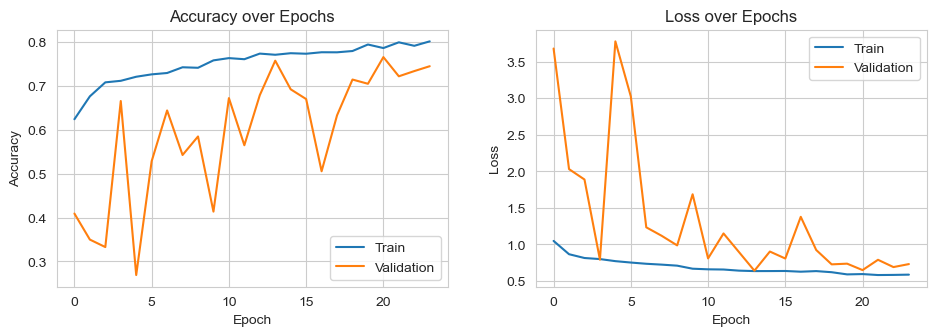

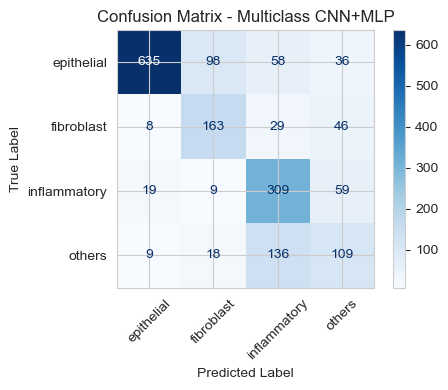

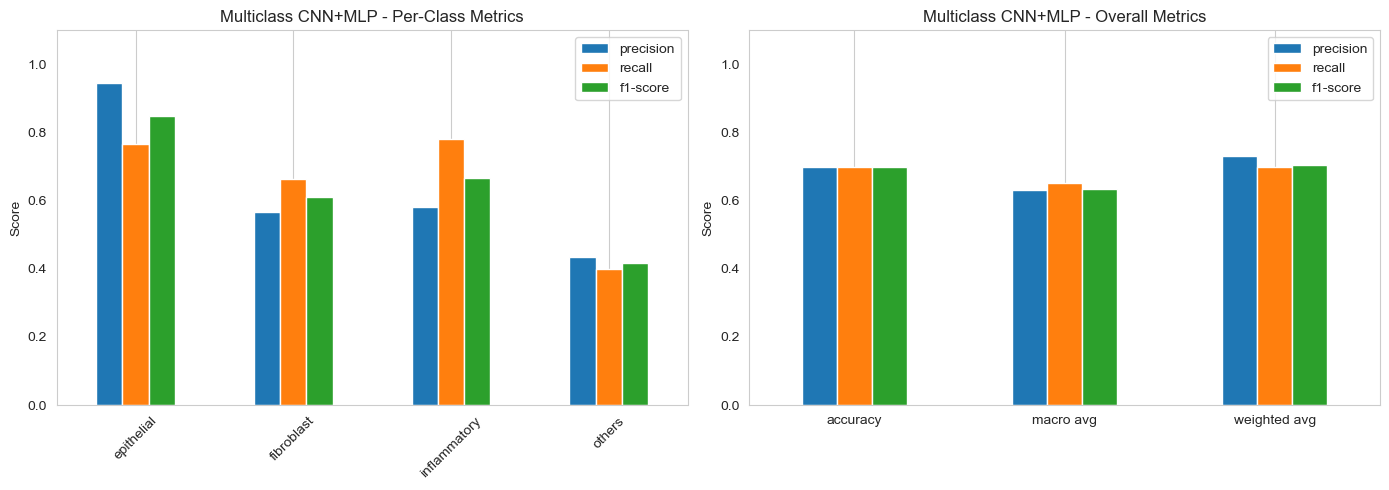


==== Multiclass CNN+MLP - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.95      0.77      0.85       827
  fibroblast       0.57      0.66      0.61       246
inflammatory       0.58      0.78      0.67       396
      others       0.44      0.40      0.42       272

    accuracy                           0.70      1741
   macro avg       0.63      0.65      0.64      1741
weighted avg       0.73      0.70      0.71      1741



In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

model_multi_cnn_no_reg = Sequential([
    #first convolutional block: extract spatial features...
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
    BatchNormalization(),                    #normalize activations...
    MaxPooling2D(2, 2),                      #downsample...

    #second convolutional block: for deeper features...
    Conv2D(64, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(2, 2),

    #flatten feature...
    Flatten(),
    #combine extracted features...
    Dense(128, activation='relu'),
    #output layer with softmax activation for 4 classs classification...
    Dense(4, activation='softmax')])

#compile model using Adam optimizer and categorical crossentropy loss...
model_multi_cnn_no_reg.compile(
    optimizer=Adam(learning_rate=lr),          
    loss='categorical_crossentropy', metrics=['accuracy']
)

#train...
history_multi_cnn_no_reg = model_multi_cnn_no_reg.fit(
                            train_generator_multi,   
                            validation_data=val_generator_multi,
                            epochs=epochs,
                            callbacks=callbacks,
                            class_weight=class_weights_dict_multi,
                            verbose=0)

#evaluate
test_loss, test_acc = model_multi_cnn_no_reg.evaluate(test_generator_multi, verbose=0)

print(f'Multi-Class CNN + MLP (No Regularization) Test Accuracy: {test_acc:.4f}')

y_pred_probs = model_multi_cnn_no_reg.predict(test_generator_multi)
y_pred_labels = np.argmax(y_pred_probs, axis=1)
y_true_labels = np.argmax(y_test_multi, axis=1) 

plot_learning_curve(history_multi_cnn_no_reg)

plot_confusion_matrix(
    y_true=y_true_labels,
    y_pred=y_pred_labels,
    label_names=label_encoder.classes_,
    model_name="Multiclass CNN+MLP"
)

plot_classification_metrics(
    y_true=y_true_labels,
    y_pred=y_pred_labels,
    label_names=label_encoder.classes_,
    model_name="Multiclass CNN+MLP"
)

print(f"\n==== Multiclass CNN+MLP - Classification Report ====")
print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_, zero_division=0))



### **Independent Model Evaluation for CNN+MLP for Cell type (no regularization)** 

Training stopped early at epoch 27, with test accuracy of 69.84%, showing improvement over base MLP. The learning curve suggests instability and mild overfitting but performance is still better overall.

Confusion matrix and bar charts show class weighting helped address imbalance. Epithelial cells were best classified (635 correct, 192 false positives), followed by inflammatory cells (309 correct, 87 false positives). Other types also showed imprvement.

Precision and recall reached 73% (weighted) and 63% (macro), confirming better balance across all classes compared to base model.


### Regularization for Cell Type Classification

We developed an enhanced CNN + MLP model with 
* deeper convolutional blocks,
* increased filters (32->128),
* a dense layer with 512 units,
* and Dropout(0.5) for regularization.

L2 regularization was initialy applied to both convolutional and dense layers. But performance dropped at moderate to high L2 values likely due to over-regularizing convolutional layers, which are critical for learning spatial features. Combined with Dropout, this led to underfitting. To fix this, we applied L2 only to the dense layer where its more effective. This adjusted model was then used to experiment with different L2 strengths under same training conditions.



Trying: L2=1e-05, Initial Learning Rate=0.001
Final Learning Rate: 0.000125
Test Accuracy: 0.7053


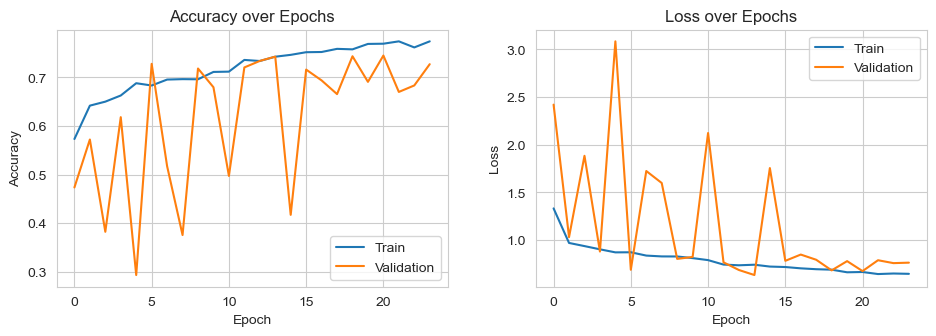

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step


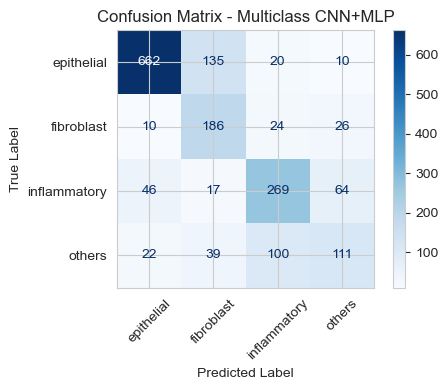

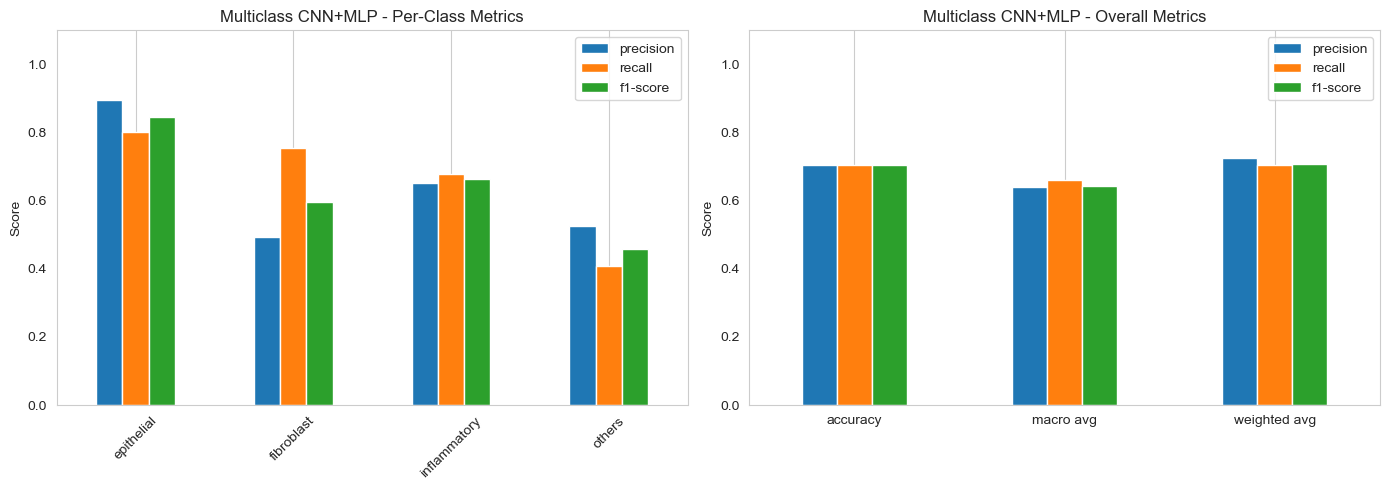


==== Multiclass CNN+MLP - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.89      0.80      0.84       827
  fibroblast       0.49      0.76      0.60       246
inflammatory       0.65      0.68      0.67       396
      others       0.53      0.41      0.46       272

    accuracy                           0.71      1741
   macro avg       0.64      0.66      0.64      1741
weighted avg       0.72      0.71      0.71      1741


Trying: L2=0.0001, Initial Learning Rate=0.001
Final Learning Rate: 0.000008
Test Accuracy: 0.7484


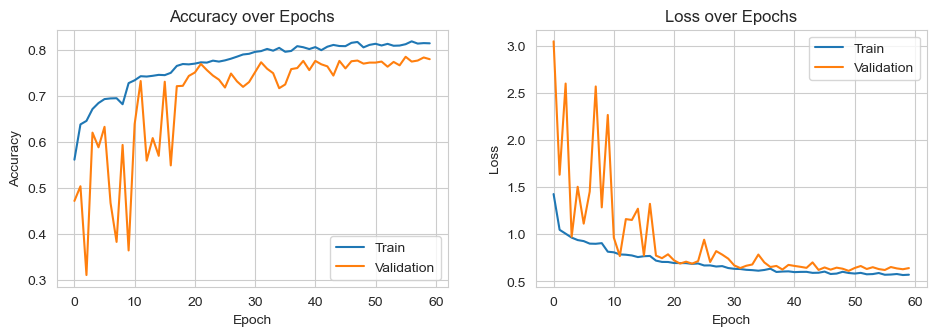

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


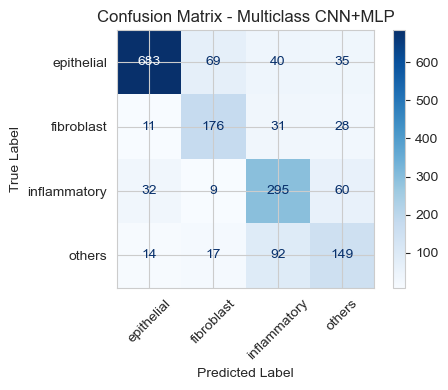

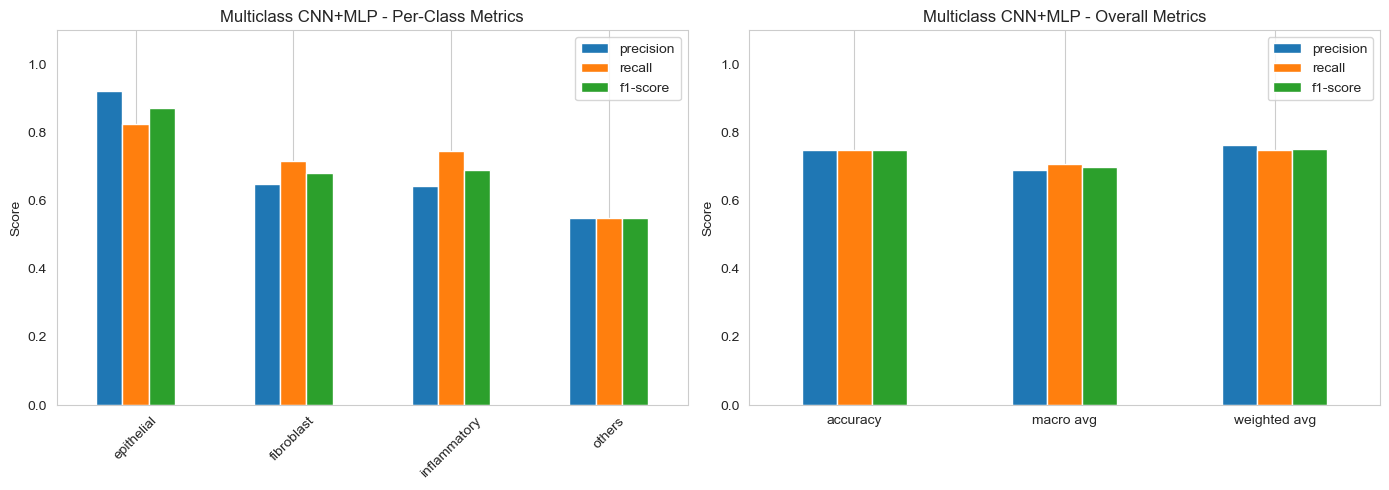


==== Multiclass CNN+MLP - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.92      0.83      0.87       827
  fibroblast       0.65      0.72      0.68       246
inflammatory       0.64      0.74      0.69       396
      others       0.55      0.55      0.55       272

    accuracy                           0.75      1741
   macro avg       0.69      0.71      0.70      1741
weighted avg       0.76      0.75      0.75      1741


Trying: L2=0.0005, Initial Learning Rate=0.001
Final Learning Rate: 0.000008
Test Accuracy: 0.7352


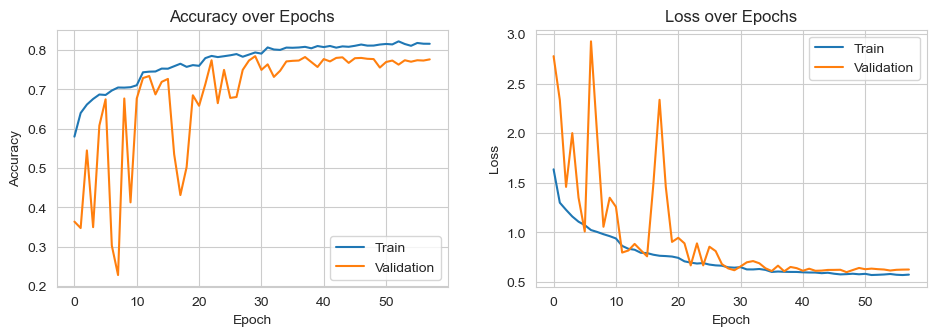

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


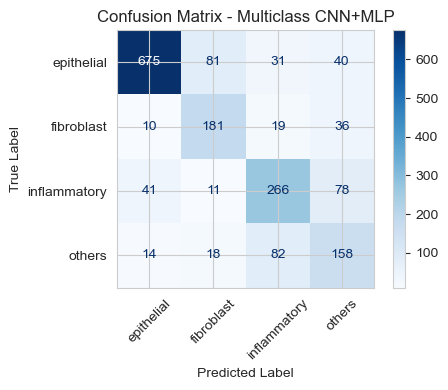

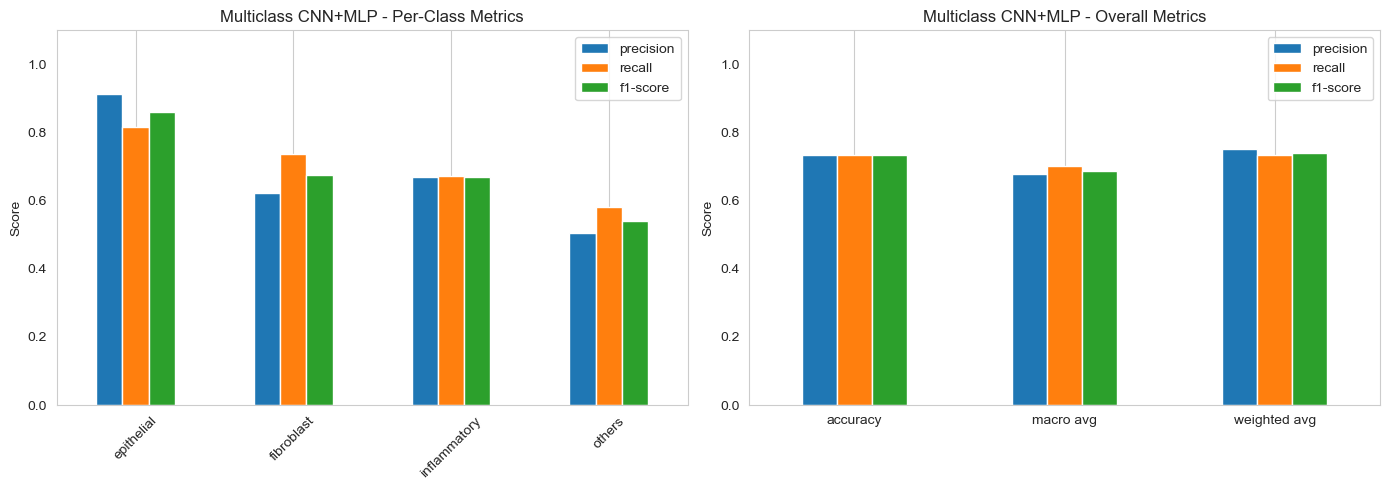


==== Multiclass CNN+MLP - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.91      0.82      0.86       827
  fibroblast       0.62      0.74      0.67       246
inflammatory       0.67      0.67      0.67       396
      others       0.51      0.58      0.54       272

    accuracy                           0.74      1741
   macro avg       0.68      0.70      0.69      1741
weighted avg       0.75      0.74      0.74      1741


Trying: L2=0.005, Initial Learning Rate=0.001
Final Learning Rate: 0.000031
Test Accuracy: 0.7725


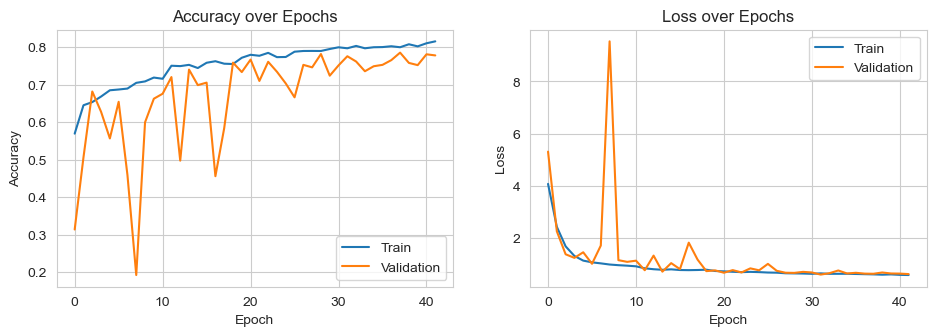

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step


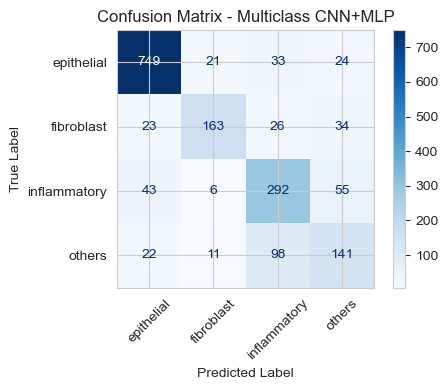

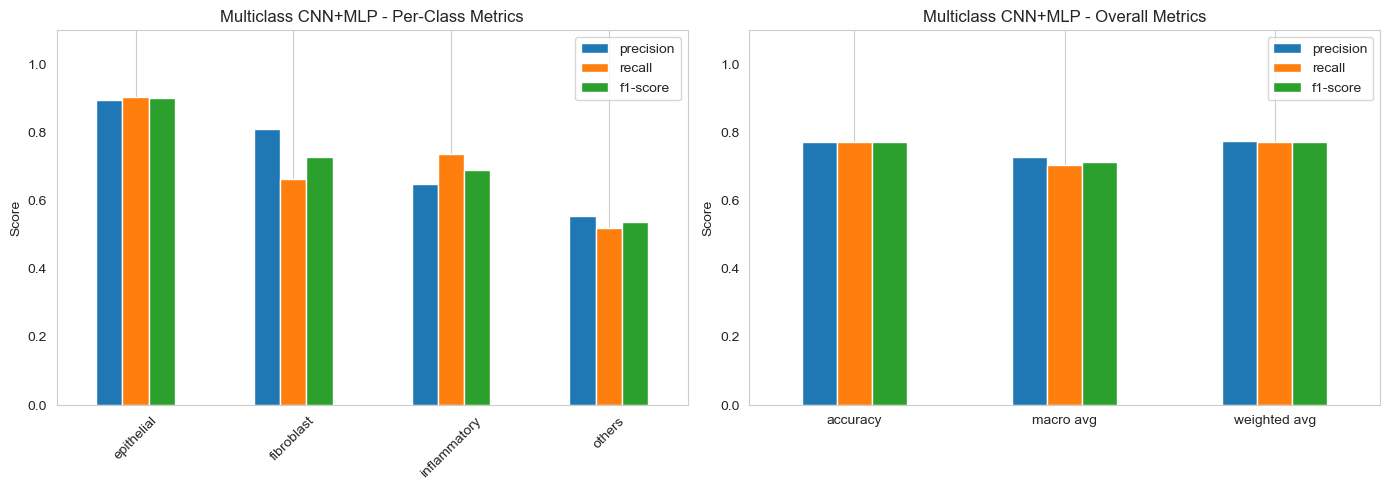


==== Multiclass CNN+MLP - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.89      0.91      0.90       827
  fibroblast       0.81      0.66      0.73       246
inflammatory       0.65      0.74      0.69       396
      others       0.56      0.52      0.54       272

    accuracy                           0.77      1741
   macro avg       0.73      0.71      0.71      1741
weighted avg       0.77      0.77      0.77      1741



In [51]:
# L2 regularization strength and learning rate....
#l2_values_multi = [0.0, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]  #we have experimented all these..
l2_values_multi = [0.00001, 0.0001, 0.0005, 0.005]
for l2_val in l2_values_multi:
    print(f"\nTrying: L2={l2_val}, Initial Learning Rate={lr}")

    model_multi_cnn = Sequential([
        Input(shape=input_shape), 
        #first block: two conv layers with ReLU and BatchNorm...
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        Conv2D(32, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),              #downsample...

        #second block: two conv layers with more filters (128)...
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        Conv2D(128, (3,3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(2, 2),

        #flatten...
        Flatten(),
        #fully connected dense layer with L2 regularization..
        Dense(512, activation='relu', kernel_regularizer=l2(l2_val)),

        #dropout added for regularization...
        Dropout(0.5),
        #output layer with softmax activation for multiclass prediction..
        Dense(num_classes, activation='softmax')
    ])

    #categorical crossentropy for multiclass classification...
    model_multi_cnn.compile(optimizer=Adam(learning_rate=lr), loss='categorical_crossentropy', metrics=['accuracy'])

    #train...
    history_multi_cnn_reg = model_multi_cnn.fit(
        train_generator_multi,
        validation_data=val_generator_multi, 
        epochs=epochs,  
        callbacks=callbacks, 
        class_weight=class_weights_dict_multi,
        verbose=0
    )

    #evaluate..
    test_loss, test_acc = model_multi_cnn.evaluate(test_generator_multi, verbose=0)
    
    current_lr = float(tf.keras.backend.get_value(model_multi_cnn.optimizer.learning_rate))
    
    print(f"Final Learning Rate: {current_lr:.6f}")
    print(f"Test Accuracy: {test_acc:.4f}")
    
    plot_learning_curve(history_multi_cnn_reg)
    
    y_pred_probs = model_multi_cnn.predict(test_generator_multi)
    y_pred_labels = np.argmax(y_pred_probs, axis=1)
    y_true_labels = np.argmax(y_test_multi, axis=1)
    
    plot_confusion_matrix(
    y_true=y_true_labels,
    y_pred=y_pred_labels,
    label_names=label_encoder.classes_,
    model_name="Multiclass CNN+MLP"
    )

    plot_classification_metrics(
    y_true=y_true_labels,
    y_pred=y_pred_labels,
    label_names=label_encoder.classes_,
    model_name="Multiclass CNN+MLP"
    )

    print(f"\n==== Multiclass CNN+MLP - Classification Report ====")
    print(classification_report(y_true_labels, y_pred_labels, target_names=label_encoder.classes_, zero_division=0))




### **Independent Model Evaluation for CNN + MLP for cell-type classification (regularized):** 

All L2 configurations triggered early stopping, with best test accuracy at 77%(learning rate reduced to 0.000031 via LR scheduler). Learning curve was unstable for first 20 epochs, then improved, indicating better generalization.

Confusion matrix shows stronger diagonal values fewer false predictions. Bar charts confirm improved performance across all cell types, with class imbalance addressed. Despite epithelial being dominant, other classes are now better predicted.

Macro and weighted averages reached 73% and 77%, shwing improvement over both base and unregularized models.

## Random Forest for Cell Type Classification

To explore alternatives beyond deep learning, we implemented a Random Forest classifier for the cell type classification task.Though not a baseline, it offered an interpretable, non-neural perspective and helped assess whether simpler models could perform competitively.

The results we got were the following:

| Metric        | Random Forest (No Regularization) | Random Forest (With Regularization) |
|---------------|-----------------------------------|------------------------------------|
| Test Accuracy | 0.6990                            | 0.7122                             |
| Precision     | 0.64                             | 0.52                              |
| Recall        | 0.58                             | 0.60                              |
| F1-Score      | 0.54                             | 0.55                              |



Due to word count limits we had to remove it from this investigation however the results are used to contrast with other models.

# Can Extra Data improve our cell-type prediction?

### Semi-Supervised Learning (SSL)

**What is Semi-Supervised Learning?**
Combines labeled and unlabeled data to improve model performance. Useful in fields like medical imaging, where labeled data is limited.

**Why It Makes Sense in This Project?**
* We had labeled data from patients 1–60 and unlabeled data frm patients 61–99 hence had opportunity to retrain on the CNN + MLP model.

**Strengths and Limitations**
* **Strengths:**
    * Increased training data without manual labeling...
    * Allowed us to explore how to handle real world unlabeled data...
    * Improved model exposure to new patient variations...

* **Limitations:**
    * Pseudo-labels were assumed 100% correct..
    * Model might redo its own mistakes, especialy for underrepresented classes.
    * Unclear if this approach will always lead to consistent improvements...

**Real-World Applicability of SSL in Medical Imaging**

SSL is widely used in medical imaging to reduce labeling effort and boost generalization, e.g., tumor classifiers.

**Self Organizing Maps(SOM)**:
Although our primary implementation relied on CNN+MLP based architectures for feature extraction and classification, lab concepts such as Self-Organizing Maps (SOMs) ofer promising future dirctions for semisupervised learning. SOMs introduced in earlier labs(lab 10), could be used to cluster high dimensional histopathology image features and project them onto a 2D grid.

In next cell to make use of **semi-supervised learning**, we applied pseudo labeling to the unlabeled extra_data containing patients 61–99.

In [65]:
#filter extra_data for patients 61 to 99..
extra_data_filtered = extra_data[extra_data['patientID'].between(61, 99)]

#predict cell types from the trained CNN model..[no reg]
extra_img_names = extra_data_filtered['ImageName'].values
X_extra = load_images(extra_img_names, image_dir=image_folder)
y_extra_probs = model_multi_cnn_no_reg.predict(X_extra)
#here predctign as integers..
y_extra_preds = np.argmax(y_extra_probs, axis=1)

#decode predictions using LabelEncoder trained on main_data.. 
label_encoder = LabelEncoder()
#predicting celltypename..
label_encoder.fit(main_data['cellTypeName'])

#predicting class names as numeric labels..
y_extra_labels = label_encoder.inverse_transform(y_extra_preds)
extra_data_filtered['cellTypeName'] = y_extra_labels

#encode cellTypeName as float for cellType field
extra_data_filtered['cellType'] = label_encoder.transform(y_extra_labels).astype(float)
extra_data_filtered.to_csv("prediction_on_extra.csv", index=False)


325/325 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


 We merged the orignal labeled dataset and pseudo-labeled predictions generated for the extra dataset to get pseudo_combined.csv

In [67]:
#joining both data sets.. main + extra
main_data = pd.read_csv("data_labels_mainData.csv")
extra_data = pd.read_csv("prediction_on_extra.csv")

print(main_data.columns)
print(extra_data.columns)

#here we are combining both csv files...
pseudo_combined = pd.concat([main_data, extra_data], ignore_index=True)

pseudo_combined.to_csv("pseudo_combined.csv", index=False)

Index(['InstanceID', 'patientID', 'ImageName', 'cellTypeName', 'cellType',
       'isCancerous'],
      dtype='object')
Index(['InstanceID', 'patientID', 'ImageName', 'isCancerous', 'cellTypeName',
       'cellType'],
      dtype='object')


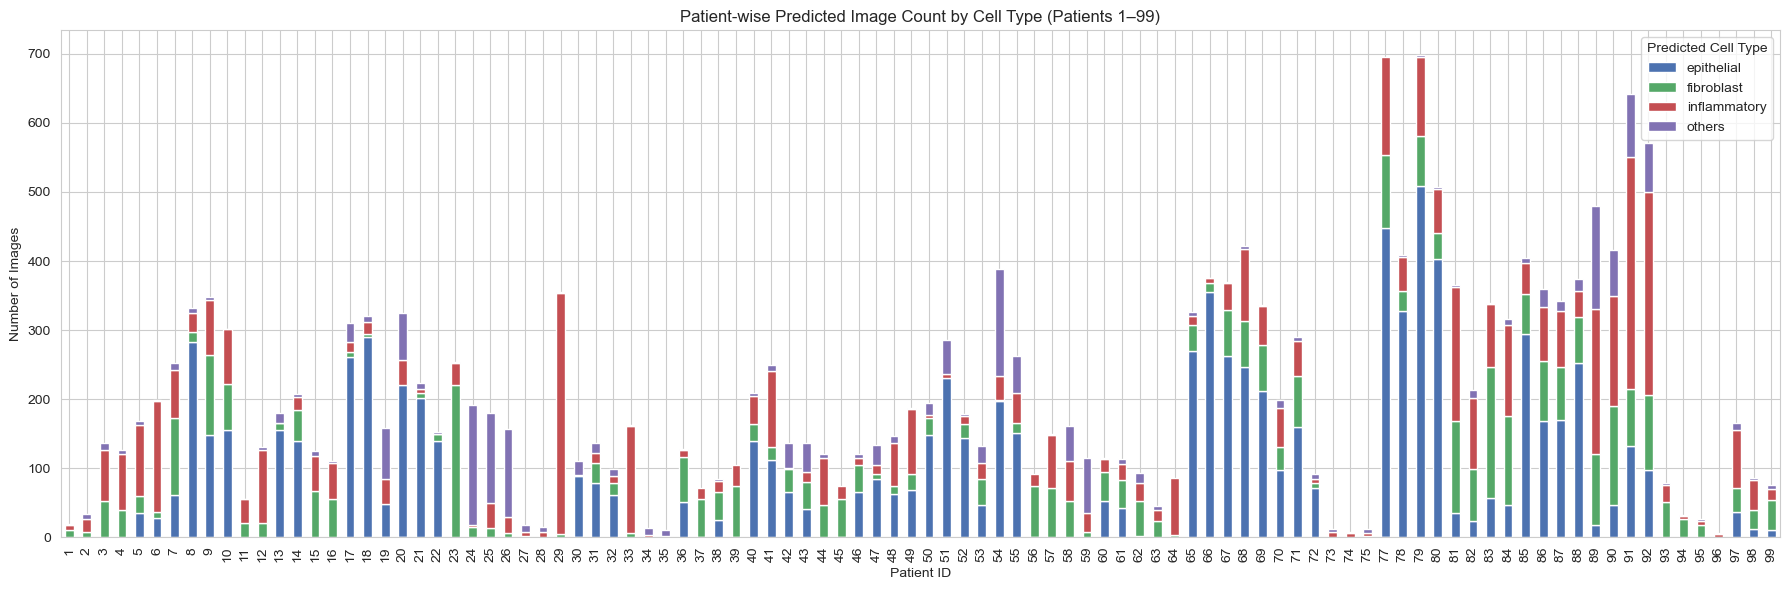

In [68]:
#just to compare visually.. for the combined data set this is showing hte cell type..
predicted_extra = pd.read_csv("pseudo_combined.csv") 

pivot_pred_celltype = predicted_extra.groupby(['patientID', 'cellTypeName']).size().unstack(fill_value=0)
pivot_pred_celltype.plot(kind='bar', stacked=True, figsize=(18, 6),
                         color=['#4C72B0', '#55A868', '#C44E52', '#8172B3'])  

plt.title('Patient-wise Predicted Image Count by Cell Type (Patients 1–99)')
plt.xlabel('Patient ID')
plt.ylabel('Number of Images')
plt.legend(title='Predicted Cell Type')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


To understand the distribution of predicted cell types for patients 1–99, we show the nos of image patches assigned to each cell type per patient ID using a bar chart. 
* Patients in the first half (1–60) display a more balanced and expected distribution across the four classes.
* In contrast, sme patients in the pseudo-labeled half(61-99) show a dominance of certain cell typs, especially inflammatory and epithelial, which shows how the model tends to predcct the majority classes.
* This visualization helps detect class imbalances introduced by the pseudo-labeling process.

In next cell, we preprocessing in the full dataset by loading and applying same techniques as before

Stratification for data balance among splits.


In [71]:
#load pseudo-labeled data..[combined data]
df = pd.read_csv("pseudo_combined.csv")
df['ImageName'] = df['ImageName'].str.strip()

#encode categorical cell type labels....
label_encoder = LabelEncoder()
df['cellType'] = label_encoder.fit_transform(df['cellTypeName'])

#did it a bit different from the splitting earlier using hte tut lab 10.. approach is same..
patient_labels = df.groupby('patientID')['cellTypeName'].agg(lambda x: x.mode().iloc[0])
patients = patient_labels.index.values
labels = patient_labels.values

#70% Train, 15% Validation, 15% Test
train_p, temp_p, y_train_p, y_temp_p = train_test_split(
    patients, labels, stratify=labels, test_size=0.3, random_state=42)
val_p, test_p, y_val_p, y_test_p = train_test_split(
    temp_p, y_temp_p, stratify=y_temp_p, test_size=0.5, random_state=42)

#patient-wise and stratified..
train_df = df[df['patientID'].isin(train_p)]
val_df = df[df['patientID'].isin(val_p)]
test_df = df[df['patientID'].isin(test_p)]

Reused the same image augmentation pipeline(train_aug) and data loading logic from our earlier experiment to ensure consistency when working with the expanded dataset(patients 1–99):

In [73]:
image_folder = "patch_images"
#load images..
X_train = load_images(train_df['ImageName'].values, image_folder)
X_val = load_images(val_df['ImageName'].values, image_folder)
X_test = load_images(test_df['ImageName'].values, image_folder)

#one hot encode the cellType label..
y_train = to_categorical(train_df['cellType'].values)
y_val = to_categorical(val_df['cellType'].values)
y_test = to_categorical(test_df['cellType'].values)

#create image generators..
train_generator_multi = train_aug.flow(X_train, y_train, batch_size=batch_size, shuffle=True, seed=SEED)
val_generator_multi = val_test_aug.flow(X_val, y_val, batch_size=batch_size, shuffle=False)
test_generator_multi = val_test_aug.flow(X_test, y_test, batch_size=batch_size, shuffle=False)

Checks real labels and pseudo-labels predicted by the original CNN+MLP model.

In [75]:
#CNN + MLP model for multiclass classification (4 cell types)...
model = Sequential([
    #first convolutional block..
    Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),                 
    BatchNormalization(),                    #normalise activation..
    MaxPooling2D(2, 2),                      #reduce pooling...

    #second convolutional block..
    Conv2D(64, (3, 3), activation='relu'), 
    BatchNormalization(), 
    MaxPooling2D(2, 2), 
    
    #flattening..
    Flatten(),

    #combine features..
    Dense(128, activation='relu'), 
    #softmax acitivation for multi class like before..
    Dense(4, activation='softmax')])


model.compile(optimizer=Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy',   #for mmulticlass..
              metrics=['accuracy'])

#train..
history = model.fit(
    train_generator_multi,
    validation_data=val_generator_multi,
    epochs=epochs,
    batch_size=batch_size,
    callbacks=callbacks,
    class_weight=class_weights_dict_multi
)

#evaluate..
test_loss, test_acc = model.evaluate(test_generator_multi)

print("\nModel training completed.")
print(f"Test Accuracy(SSL): {test_acc:.4f}")
print(f"Test Loss: {test_loss:.4f}")

Epoch 1/100


/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.5731 - loss: 1.1200 - val_accuracy: 0.5672 - val_loss: 0.9859 - learning_rate: 1.0000e-04
Epoch 2/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 13ms/step - accuracy: 0.6956 - loss: 0.8183 - val_accuracy: 0.6655 - val_loss: 0.8345 - learning_rate: 1.0000e-04
Epoch 3/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 7s 17ms/step - accuracy: 0.7203 - loss: 0.7603 - val_accuracy: 0.7541 - val_loss: 0.6326 - learning_rate: 1.0000e-04
Epoch 4/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 8s 20ms/step - accuracy: 0.7279 - loss: 0.7351 - val_accuracy: 0.6994 - val_loss: 0.7782 - learning_rate: 1.0000e-04
Epoch 5/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7387 - loss: 0.7040 - val_accuracy: 0.6964 - val_loss: 0.7374 - learning_rate: 1.0000e-04
Epoch 6/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy: 0.7544 - loss: 0.6776 - val_accuracy: 0.7637 - val_loss: 0.6248 - learning_rate: 1.0000e-04
Epoch 7/100
421/421 ━━━━━━━━━━━━━━━━━━━━ 6s 15ms/step - accuracy

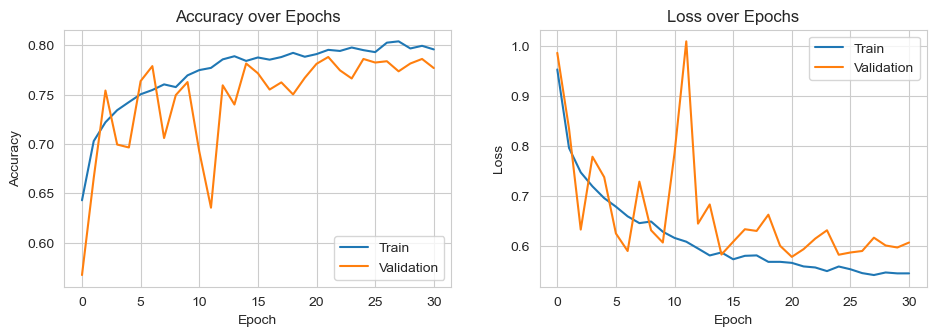

119/119 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


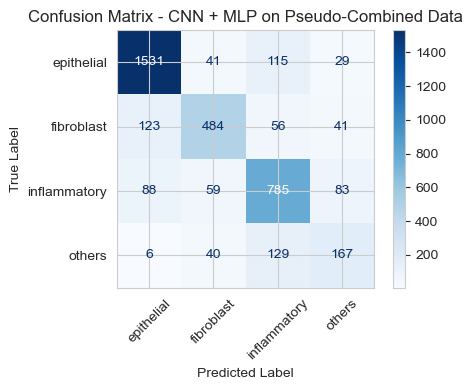

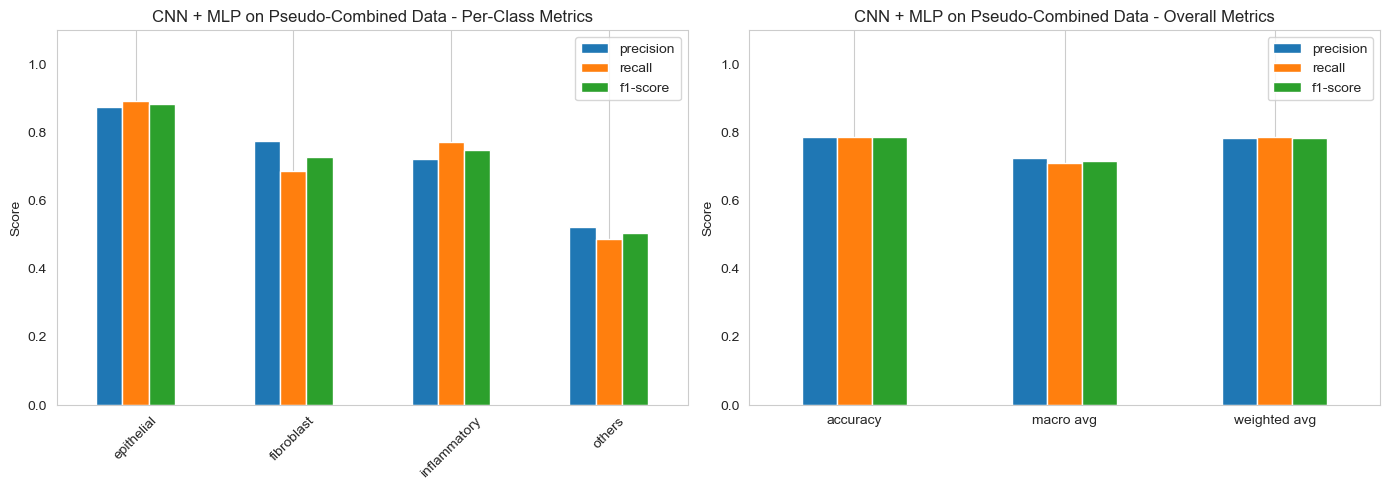


==== CNN + MLP on Pseudo-Combined Data - Classification Report ====
              precision    recall  f1-score   support

  epithelial       0.88      0.89      0.88      1716
  fibroblast       0.78      0.69      0.73       704
inflammatory       0.72      0.77      0.75      1015
      others       0.52      0.49      0.50       342

    accuracy                           0.79      3777
   macro avg       0.72      0.71      0.72      3777
weighted avg       0.78      0.79      0.78      3777



In [76]:
#plot learning curves (accuracy + loss)
plot_learning_curve(history, metric_name='accuracy')

#predict on test set
y_pred = np.argmax(model.predict(X_test), axis=1)
y_true = np.argmax(y_test, axis=1)

#plot confusion matrix
plot_confusion_matrix(
    y_true=y_true,
    y_pred=y_pred,
    label_names=label_encoder.classes_,
    model_name="CNN + MLP on Pseudo-Combined Data"
)

#plot classification metrics (per-class + overall scores)
plot_classification_metrics(
    y_true=y_true,
    y_pred=y_pred,
    label_names=label_encoder.classes_,
    model_name="CNN + MLP on Pseudo-Combined Data"
)
print(f"\n==== CNN + MLP on Pseudo-Combined Data - Classification Report ====")
print(classification_report(y_true, y_pred, target_names=label_encoder.classes_, zero_division=0))




## Evaluation of Extra data with CNN + MLP (non-regularized model):

We are comparing this model to the non-regularized CNN + MLP model for cell type classification. 

With pseudo-labeled data, the model achieved 78.55% accuracy and early stopped after epoch 30. Despite a sharp drop in accuracy around epochs 11–12, the model recovered and generalized well.

Confusion matrix shows epithelial cells are most accurately predicted (1531 correct) with strong diagonal values overall. But the 'others' class remains challenging, with 129 misclassified as inflammatory.

Bar charts show class imbalance was addressed, with precision and recall reaching 78% and 79% (weighted), outperforming previous models.

## Ultimate Judgement

Through the several different models that were explored in this model some performed better than others. The two targets we are looking at for this investigation is binary classification of isCancerous and Multi-Class Classification of Cell type. 

### 🏆 Best Model for `isCancerous`

`MLP + CNN hybrid model with regularization with a LR of 0.000016`

The best model for binary classification of isCancerous cell is the one above. The test accuracy for this model is 90.12% which shows extremely good results. This model shows it generalizes well with unseen data has a low val_loss and it's learning curve and bar charts show good results rather than class imbalance and overfitting. Furthermore when exploring other metrics such as recall, precision and f1 score they all sit at 90% indicating the model is predicting well. The model does show that it is better at predicting non-cancerous cells at 95% recall compared to 83% recall on cancerous cells.

### 🏆 Best Model for `Cell Type`

`MLP + CNN Hybrid model (unregularized) with extra data`

The reason for this being the best model for multi-class classification is that it performed extremely well with an accuracy of 78.55% despite being unregularized. From this we can assume that if this model were to be regularized it would surpass an accuracy is 78.55%. The charts show us the model is well balanced across all metrics sitting at around 78% as a weighted average for the f1 score which shows us a balance of recall and precision. All models related to cell type were best at capturing epithelial cells with this model in particular having a recall of 89% and f1 score of 88% for epithelial cells. Similarly the worst type to predict is at 'others' sitting at 50% recall and 49% precision.

## Conclusion and Future Work

In conclusion after experimenting with several different models it can be determined that a CNN model is very suitable in predicting isCancerous cells and Cell type classifications. From our results we can see that regularization is required to make sure that the model generalizes well and our independant evalution shows that there is room for improvement with our cell type classifcation model.

In the future, other models should be studied such as FCN used by Chen et al and also possibly experiment with a regularized version of the CNN + MLP model with extra data as an unregularized version showed promising results.

## Appendix

### Independent Evaluation (Research)

We will use two seperate articles to discuss both of the targets for this investigation. 

The article we will use to discuss the binary classification of isCancerous is

**Chen, H.; Qi, X.; Yu, L.; Dou, Q.; Qin, J.; Heng, P.A. DCAN: Deep Contour-Aware Networks for Object Instance Segmentation
from Histology Images. Med. Image Anal. 2017, 36, 135–146.**


The article to discuss Multi-class classification is

**Shapcott, M.; Hewitt, K.J.; Rajpoot, N. Deep Learning With Sampling in Colon Cancer Histology. Front. Bioeng. Biotechnol. 2019, 7, 52.**

`Binary Classification`

In the article Chen et al attempt to discover with a cell is benign or malignant. This is the equivalent to whether the cell is non-cancerous or cancerous where a benign cell is considered non-cancerous. 

This article had a  approach of using a FCN (Fully Convulutional network) to build their model with max-pooling layers and convulutional layers. The authors used two models to compare their results one was FCN without integrating contour-aware component and the other was deep contour-aware network (DCAN). They are named CUMedVision1 and CUMedVision2.

The performance was measured by the following metrics:
F1 score, object-level Dice index and Hausdorff distance.

To compare with our model we will use the F1 score as the common metric and see how well the model fares.

| Model                            | Overall F1-score | Non-Cancerous F1 | Cancerous F1 |
|----------------------------------|------------------|------------------|--------------|
| Binary MLP (base)                | 0.82             | 0.84             | 0.79         |
| Binary CNN + MLP (unregularized)| 0.88             | 0.91             | 0.85         |
| Binary CNN + MLP (regularized)  | **0.90**         | **0.92**         | **0.87**     |
| CUMedVision1                    | 0.856            | 0.872            | 0.788        |
| CUMedVision2                    | 0.887            | 0.919            | 0.771        |

The results show that that the Binary CNN + MLP (regularized) remains the best model achieving a very high f1 score compared both of the new models. This could be due to many factors such as the number of images, different pre-processing, layers and their model architecture itself as well as many other factors. Realistically as both models are using the same data the results should be consistent and the current model should be superior however as there are other metrics measured in the article is difficult to determine whether or not it is truly the better model. It is unclear as to what may be the single factor that proves our model is better than Chen et al, although it may include things such as model complexity or fine tuning parameters as the difference is small.

(Note: In the above table the regularized model results are from the best performing model which are observable above)

`Multi-class Classification`


The approach of Shapcott et al was very similar to our own where they created a CNN to predict the target. Some differences in their approach that were observable are image sizes were 33 x 33 whereas we used 27 x 27, as well as the batch size was 128 wheras we used 32 and the number of epochs was significantly higher at 350 whereas we had 100 with early stopping. Random sampling and data splitting was also used to tune parameters. 

The metric used to measure the performance was accuracy so to compare and contrast our results we will use accuracy from our models. 

| Model                                  | Accuracy |
|----------------------------------------|----------|
| **Shapcott et al. CNN**                    | **0.84**     |
| Multiclass MLP                         | 0.43     |
| CNN + MLP (Unregularized, small data)  | 0.70     |
| CNN + MLP (Regularized, small data)    | 0.77     |
| Random Forest (No Regularization)      | 0.70     |
| Random Forest (Regularized)            | 0.71     |
| CNN + MLP (With Extra Data)            | 0.79     |

Observed Shapcott et al surpassed our best model with an accuracy of 84%. It is far superior than all the other models and the closest one comparable is the unregularized model with the extra data. There are several different reasons as to why this may be the case including different pre-processing which is evident in their article as well as number of layers and image sizes and just general approach. It is not possible to conclusively determine what factor led to the increase in the performance as there are too many factors to investigate. 

In terms of fairness and consistency it should be noted that simply the accuracy is not always a good measure of a model's performance and should include metrics such as f1-score to gauge properly what the model is capable of and hence the comparison was limited to an extent. However as their model was tested on a hold-out set it is most likely an indication that the model does generalize well.


(Note: In the above table the regularized model results are from the best performing model which are observable above)



### Metrics for performance and class imbalance

Accuracy:
Proportion of total correct predictions out of all predictions made. 

Precision:
Proportion of correctly predicted positives out of all predicted positives.

Recall:
Proportion of correctly predicted positives out of all actual positives.

F1 Score:
Harmonic mean of precision and recall, balancing false positives and false negatives.

Validation Loss:
Error calculated on validation data; lower loss indicates better generalization.

### Reference 
* **Adam**: [https://medium.com/@alok.yadav/taming-the-optimizers-adagrad-adam-and-rmsprop-in-deep-learning-7b0582b0ceba]
* **ReLu**: [https://machinelearningmastery.com/rectified-linear-activation-function-for-deep-learning-neural-networks/]
* **Semi-supervised Learning**:
* [https://www.altexsoft.com/blog/semi-supervised-learning/]
   * **Real-World application for Semi-Supervised Learning** :
       * **Unified Semi-supervised Active Learning for histopathological image classification**: [https://www.sciencedirect.com/science/article/abs/pii/S1361841525000891]
       * **Exploring learning environments for label-efficient cancer diagnosis**: [https://arxiv.org/pdf/2408.07988]
       * **Deep semi-supervised learning for medical image segmentation: A review**: [https://www.sciencedirect.com/science/article/abs/pii/S0957417423035546]
       * **Self supervised driven consistency training for annotation efficient histopathology image analysis**:[https://arxiv.org/abs/2102.03897]
       * **Not-so-supervised: A survey of semi-supervised, multi-instance, and transfer learning in medical image analysis**: [https://www.sciencedirect.com/science/article/abs/pii/S1361841518307588]

**Independent evalutation**

Chen, H.; Qi, X.; Yu, L.; Dou, Q.; Qin, J.; Heng, P.A. DCAN: Deep Contour-Aware Networks for Object Instance Segmentation
from Histology Images. Med. Image Anal. 2017, 36, 135–146.

Shapcott, M.; Hewitt, K.J.; Rajpoot, N. Deep Learning With Sampling in Colon Cancer Histology. Front. Bioeng. Biotechnol. 2019, 7, 52.

         